Loading and analyzing first model (non-shuffled)...
Processing result: n_train=10, hidden_size=2000, depth=4, lr=0.005, shuffled=False


/tmp/ipykernel_1958516/2954069892.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
/tmp/ipykernel_1958516/2954069892.py:77:

Processing result: n_train=100, hidden_size=2000, depth=4, lr=0.005, shuffled=False
Processing result: n_train=500, hidden_size=2000, depth=4, lr=0.005, shuffled=False
Processing result: n_train=1000, hidden_size=2000, depth=4, lr=0.005, shuffled=False
Processing result: n_train=2500, hidden_size=2000, depth=4, lr=0.005, shuffled=False
Processing result: n_train=5000, hidden_size=2000, depth=4, lr=0.005, shuffled=False
Processing result: n_train=10000, hidden_size=2000, depth=4, lr=0.005, shuffled=False
Processing result: n_train=20000, hidden_size=2000, depth=4, lr=0.005, shuffled=False

Loading and analyzing second model (shuffled)...
Processing result: n_train=10, hidden_size=2000, depth=4, lr=0.005, shuffled=True
Processing result: n_train=100, hidden_size=2000, depth=4, lr=0.005, shuffled=True
Processing result: n_train=500, hidden_size=2000, depth=4, lr=0.005, shuffled=True
Processing result: n_train=1000, hidden_size=2000, depth=4, lr=0.005, shuffled=True
Processing result: n_tr

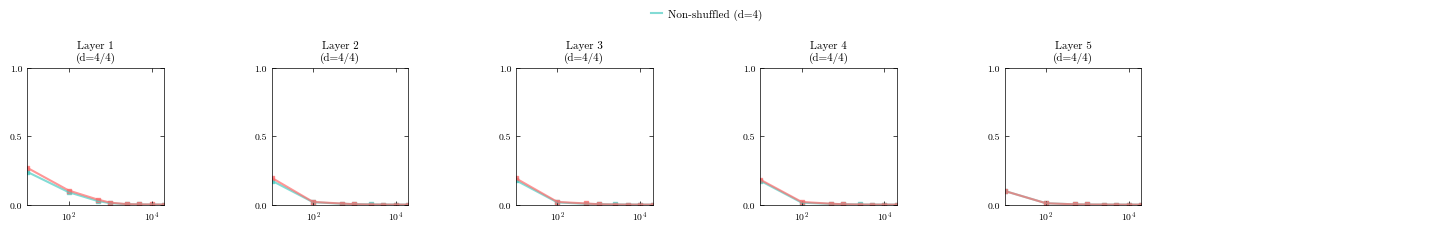

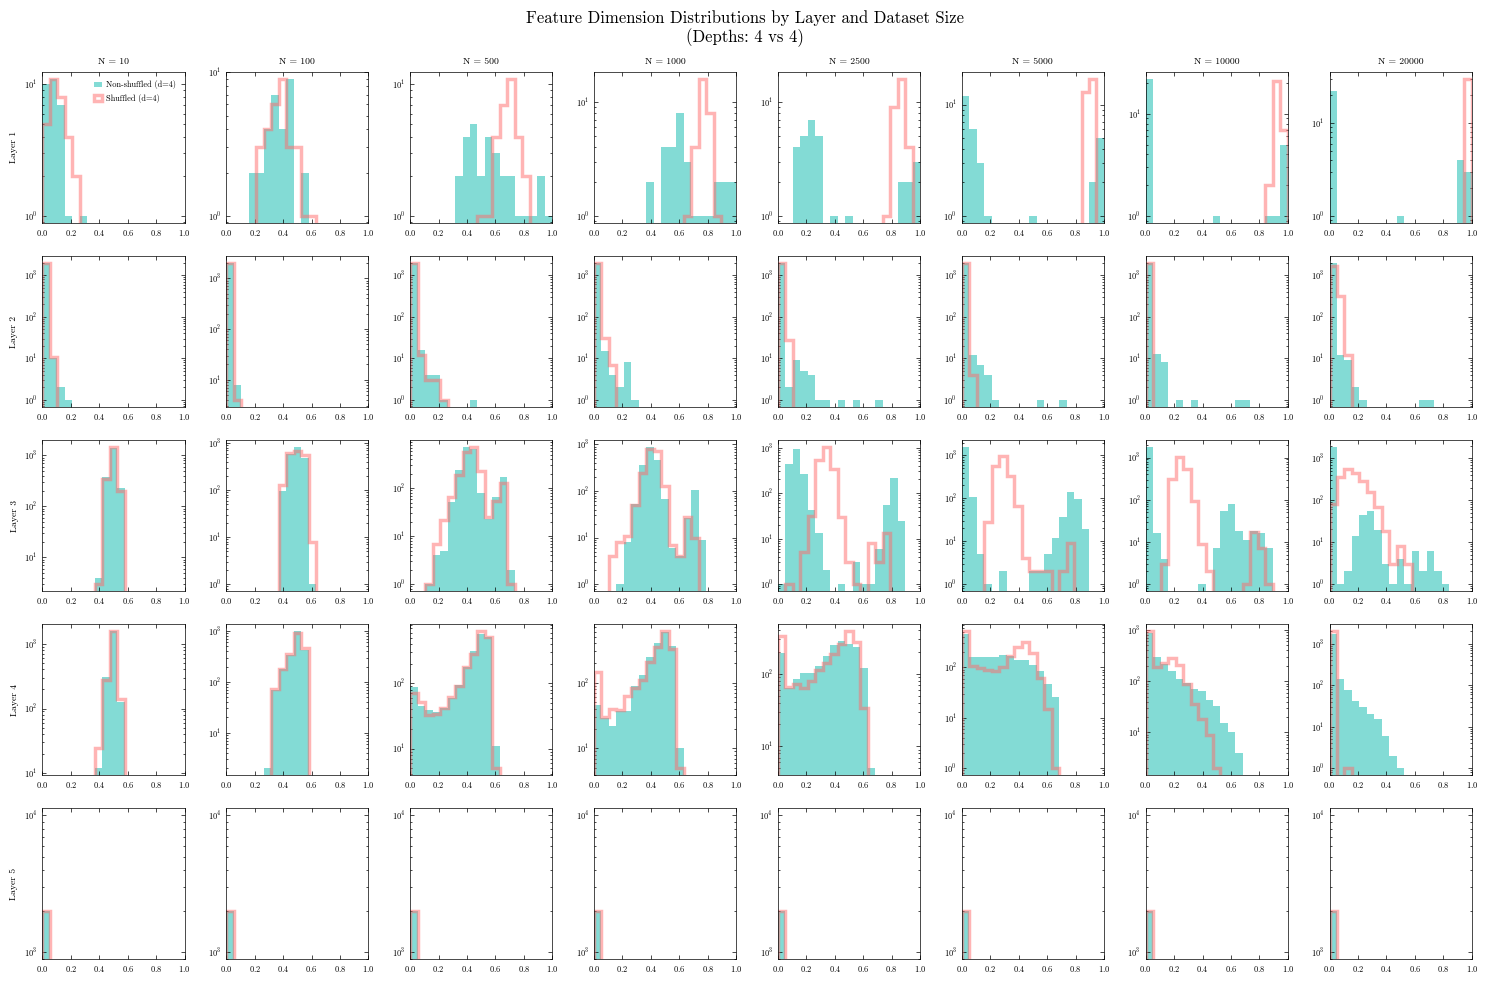

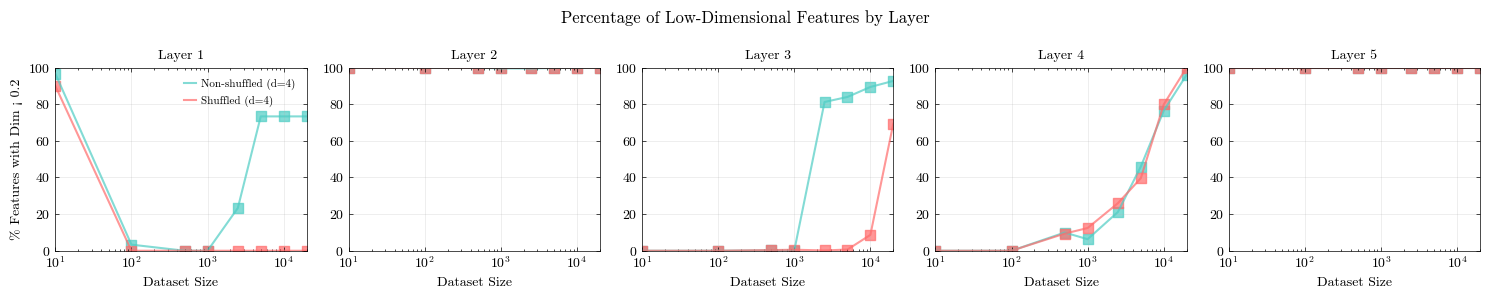

In [40]:
import torch
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List

class DeepNN(torch.nn.Module):
    def __init__(self, d: int, hidden_size: int, depth: int, mode: str = 'standard', gamma: float = 1.0):
        super().__init__()
        torch.set_default_dtype(torch.float32)
        self.gamma = gamma
        self.mode = mode
        self.depth = depth
        self.hidden_size = hidden_size
        self.input_dim = d
        
        layers = []
        prev_dim = d
        
        for layer_idx in range(depth):
            linear = torch.nn.Linear(prev_dim, hidden_size)
            if mode == 'standard':
                torch.nn.init.xavier_uniform_(linear.weight)
                torch.nn.init.zeros_(linear.bias)
            layers.extend([linear, torch.nn.ReLU()])
            prev_dim = hidden_size
        
        final_layer = torch.nn.Linear(prev_dim, 1)
        if mode == 'standard':
            torch.nn.init.xavier_uniform_(final_layer.weight)
        torch.nn.init.zeros_(final_layer.bias)
        layers.append(final_layer)
        
        self.network = torch.nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x).squeeze() / float(self.gamma)

def load_experiment_data(results_dir: str, timestamp: str) -> Tuple[List[Dict], Dict]:
    """Load experiment results and hyperparameters from the given directory"""
    hyperparams_path = os.path.join(results_dir, f'hyperparameters_{timestamp}.json')
    with open(hyperparams_path, 'r') as f:
        hyperparams = json.load(f)
    
    results_path = os.path.join(results_dir, f'final_results_{timestamp}.json')
    with open(results_path, 'r') as f:
        results = json.load(f)
    
    return results, hyperparams

def load_model_and_data(data_dir: str, results_dir: str, result: Dict, timestamp: str) -> Tuple[torch.nn.Module, torch.Tensor, torch.Tensor]:
    """Load the model and its corresponding training data"""
    hyperparams_path = os.path.join(results_dir, f'hyperparameters_{timestamp}.json')
    with open(hyperparams_path, 'r') as f:
        hyperparams = json.load(f)
    input_dim = hyperparams['d']
    
    hidden_size = result['hidden_size']
    depth = result['depth']
    n_train = result['n_train']
    lr = result['learning_rate']
    mode = result.get('mode', 'standard')
    shuffled = result.get('shuffled', False)
    rank = result.get('worker_rank', 0)
    gamma = result.get('gamma', 1.0)
    
    model_prefix = f'h{hidden_size}_d{depth}_n{n_train}_lr{lr}_g{gamma}_{mode}'
    if shuffled:
        model_prefix += '_shuffled'
    
    model_path = os.path.join(results_dir, f'final_model_{model_prefix}_{timestamp}_rank{rank}.pt')
    model = DeepNN(input_dim, hidden_size, depth, mode=mode, gamma=gamma)
    model.load_state_dict(torch.load(model_path))
    
    train_dataset_path = os.path.join(results_dir, f'train_dataset_{model_prefix}_{timestamp}_rank{rank}.pt')
    train_data = torch.load(train_dataset_path)
    
    X_train = train_data['X']
    y_train = train_data['y']
    
    device = next(model.parameters()).device
    model = model.to(device)
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    
    return model, X_train, y_train

def compute_anthropic_dimensionality(hidden: torch.Tensor, features: torch.Tensor) -> Tuple[float, float, float, float, torch.Tensor]:
    """Compute Anthropic's dimensionality metrics"""
    with torch.no_grad():
        # Sample dimensionality
        hidden_norms = torch.norm(hidden, dim=1, keepdim=True)
        normalized_hidden = hidden / (hidden_norms + 1e-8)
        hidden_dots = normalized_hidden @ hidden.T
        hidden_dots_squared = hidden_dots ** 2
        sample_denominator = torch.sum(hidden_dots_squared, dim=1)
        sample_numerator = torch.sum(hidden * hidden, dim=1)
        sample_dims = sample_numerator / (sample_denominator + 1e-8)
        
        sample_mean = float(torch.mean(sample_dims))
        sample_std = float(torch.std(sample_dims))

        # Feature dimensionality
        feature_norms = torch.norm(features, dim=0, keepdim=True)
        normalized_features = features / (feature_norms + 1e-8)
        feature_dots = normalized_features.T @ features
        feature_dots_squared = feature_dots ** 2
        feature_denominator = torch.sum(feature_dots_squared, dim=1)
        feature_numerator = torch.sum(features * features, dim=0)
        feature_dims = feature_numerator / (feature_denominator + 1e-8)
        
        feature_mean = float(torch.mean(feature_dims))
        feature_std = float(torch.std(feature_dims))

        return sample_mean, sample_std, feature_mean, feature_std, feature_dims
def analyze_by_dataset_size(results: List[Dict], hyperparams: Dict, data_dir: str, results_dir: str, 
                         timestamp: str, target_lr=None, target_hidden_size=None, target_depth=None):
    """Analyze metrics for specific model configuration"""
    # Filter results by learning rate and model architecture
    filtered_results = results
    if target_lr is not None:
        filtered_results = [r for r in filtered_results if r['learning_rate'] == target_lr]
    if target_hidden_size is not None:
        filtered_results = [r for r in filtered_results if r['hidden_size'] == target_hidden_size]
    if target_depth is not None:
        filtered_results = [r for r in filtered_results if r['depth'] == target_depth]
    
    # Sort by dataset size
    sorted_results = sorted(filtered_results, key=lambda x: x['n_train'])
    
    if not sorted_results:
        raise ValueError(f"No results found for specified configuration: lr={target_lr}, hidden_size={target_hidden_size}, depth={target_depth}")
    
    metrics = {
        'n_train': [],
        'layers': [],
        'raw_feature_dims': []  # Add storage for raw feature dimensions
    }
    
    for result in sorted_results:
        print(f"Processing result: n_train={result['n_train']}, "
              f"hidden_size={result['hidden_size']}, depth={result['depth']}, "
              f"lr={result['learning_rate']}, "
              f"shuffled={result.get('shuffled', False)}")
        
        model, X_train, y_train = load_model_and_data(data_dir, results_dir, result, timestamp)
        layer_metrics = analyze_dimensionality_by_layer(model, X_train)
        
        metrics['n_train'].append(result['n_train'])
        metrics['layers'].append(layer_metrics)
        
        # Store raw feature dimensions for each layer
        raw_dims = []
        for layer_metric in layer_metrics:
            raw_dims.append(layer_metric['anthropic']['feature_dims_raw'])
        metrics['raw_feature_dims'].append(raw_dims)
    
    return metrics

def extract_metrics_array(metrics: Dict) -> Tuple[np.ndarray, List[List[np.ndarray]], List[List[float]]]:
    """Extract metrics into numpy array and list of raw feature dimension arrays with better dimension handling"""
    if not metrics['layers']:
        raise ValueError("No metrics data found")
        
    n_layers = len(metrics['layers'][0])
    n_datapoints = len(metrics['layers'])
    n_dim_types = 4
    
    result = np.zeros((n_dim_types, n_layers, n_datapoints))
    
    # Process regular metrics
    for dp_idx, layer_metrics in enumerate(metrics['layers']):
        for layer_idx in range(n_layers):
            result[0, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['sample_dim']
            result[1, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['sample_dim_std']
            result[2, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['feature_dim']
            result[3, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['feature_dim_std']
    
    # Process raw feature dimensions - now properly structured as [dataset][layer]
    raw_feature_dims = []
    for dp_idx in range(n_datapoints):
        layer_dims = []
        for layer_idx in range(n_layers):
            dims = metrics['layers'][dp_idx][layer_idx]['anthropic']['feature_dims_raw']
            layer_dims.append(dims)
        raw_feature_dims.append(layer_dims)
    
    # Calculate percentage of feature dimensions below threshold per layer
    low_dim_percentages = [[] for _ in range(n_layers)]
    for layer_idx in range(n_layers):
        for dp_idx in range(n_datapoints):
            feat_dims = raw_feature_dims[dp_idx][layer_idx]
            low_dims = np.sum(feat_dims < 0.2)
            total_dims = len(feat_dims)
            percentage = (low_dims / total_dims) * 100 if total_dims > 0 else 0
            low_dim_percentages[layer_idx].append(percentage)
    
    return result, raw_feature_dims, low_dim_percentages



def analyze_dimensionality_by_layer(model: torch.nn.Module, X: torch.Tensor) -> Dict:
    """Compute dimensionality metrics for each layer"""
    layer_metrics = []
    current_activation = X
    
    with torch.no_grad():
        for i, layer in enumerate(model.network):
            if hasattr(layer, 'weight'):
                features = layer.weight.data
            else:
                continue
            
            current_activation = layer(current_activation)
            
            sample_mean, sample_std, feature_mean, feature_std, feature_dims = compute_anthropic_dimensionality(
                current_activation, features)
            
            layer_metrics.append({
                'layer': i,
                'anthropic': {
                    'sample_dim': sample_mean,
                    'sample_dim_std': sample_std,
                    'feature_dim': feature_mean,
                    'feature_dim_std': feature_std,
                    'feature_dims_raw': feature_dims.cpu().numpy()
                }
            })
    
    return layer_metrics

def plot_dimensionality_comparison(metrics1, metrics2, raw_dims1, raw_dims2, 
                               low_dim_pct1, low_dim_pct2,
                               label1="Model 1", label2="Model 2",
                               sample_figsize=(15.0, 2.0),
                               hist_figsize=(15, 10),
                               low_dim_figsize=(15, 3),
                               depth1=None, depth2=None):
    """Plot dimensionality analysis comparison between two models with safer array handling"""
    # Get dataset sizes from the metrics
    dataset_sizes = metrics1['n_train']
    n_layers = len(metrics1['layers'][0])
    n_datasets = len(dataset_sizes)
    
    print(f"Debug info:")
    print(f"Number of layers: {n_layers}")
    print(f"Number of datasets: {n_datasets}")
    print(f"Dataset sizes: {dataset_sizes}")
    print(f"Raw dims1 structure: {len(raw_dims1)} x {len(raw_dims1[0]) if raw_dims1 else 0}")
    print(f"Raw dims2 structure: {len(raw_dims2)} x {len(raw_dims2[0]) if raw_dims2 else 0}")
    
    # Sample Dimensionality Plot
    fig1, axs1 = plt.subplots(1, n_layers + 1, figsize=sample_figsize)
    fig1.subplots_adjust(wspace=0.01)
    
    sample_dim1 = metrics1_arr[0]
    sample_dim2 = metrics2_arr[0]
    
    # Set up consistent y-axis limits
    y_min = 0.0
    y_max = 1.0
    
    for layer in range(n_layers):
        ax = axs1[layer]
        
        ax.plot(dataset_sizes, sample_dim1[layer], color='#4ECDC4', alpha=0.7, linewidth=1.5)
        ax.plot(dataset_sizes, sample_dim2[layer], color='#FF6B6B', alpha=0.7, linewidth=1.5)
        
        ax.scatter(dataset_sizes, sample_dim1[layer], color='#4ECDC4', marker='s', s=10, alpha=0.7)
        ax.scatter(dataset_sizes, sample_dim2[layer], color='#FF6B6B', marker='s', s=10, alpha=0.7)
        
        layer_title = f'Layer {layer+1}'
        if depth1 is not None and depth2 is not None:
            layer_title += f'\n(d={depth1}/{depth2})'
        ax.set_title(layer_title, fontsize=8)
        
        ax.set_ylim(y_min, y_max)
        ax.set_yticks([0.0, 0.5, 1.0])
        ax.set_yticklabels(['0.0', '0.5', '1.0'], fontsize=7)
        
        ax.set_xscale('log')
        ax.set_xlim(10, 2e4)
        ax.set_xticks([1e2, 1e4])
        ax.set_xticklabels(['$10^2$', '$10^4$'], fontsize=7)
        
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(0.5)
            
        ax.tick_params(width=0.5)
        ax.set_box_aspect(1)
    
    axs1[-1].axis('off')
    
    if depth1 is not None and depth2 is not None:
        label1 = f"{label1} (d={depth1})"
        label2 = f"{label2} (d={depth2})"
    
    lines = axs1[0].get_lines()[::2]
    fig1.legend(lines, [label1, label2],
               loc='upper center',
               bbox_to_anchor=(0.5, 1.2),
               ncol=2,
               fontsize=8,
               frameon=False)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    
    # Feature Dimensionality Histograms with safer array handling
    fig2, axs2 = plt.subplots(n_layers, n_datasets, figsize=hist_figsize)
    title = 'Feature Dimension Distributions by Layer and Dataset Size'
    if depth1 is not None and depth2 is not None:
        title += f'\n(Depths: {depth1} vs {depth2})'
    fig2.suptitle(title, fontsize=12)
    
    x_min, x_max = 0.0, 1.0
    bins = np.linspace(x_min, x_max, 20)  # Reduced number of bins for thicker bars
    
    # Ensure axs2 is always 2D
    if n_layers == 1:
        axs2 = np.array([axs2])
    if n_datasets == 1:
        axs2 = np.array([axs2]).T
    
    for layer in range(n_layers):
        for idx in range(n_datasets):
            try:
                ax = axs2[layer, idx]
                
                # Safely access raw dimensions
                dims1 = raw_dims1[idx][layer] if idx < len(raw_dims1) and layer < len(raw_dims1[idx]) else []
                dims2 = raw_dims2[idx][layer] if idx < len(raw_dims2) and layer < len(raw_dims2[idx]) else []
                
                if len(dims1) > 0:
                    counts1, bins1, patches1 = ax.hist(dims1, bins=bins, alpha=0.7,  # Increased alpha
                                                     color='#4ECDC4', label=label1, 
                                                     histtype='stepfilled',
                                                     linewidth=2.0)  # Increased line width
                if len(dims2) > 0:
                    counts2, bins2, patches2 = ax.hist(dims2, bins=bins, alpha=0.5,
                                                     color='#FF6B6B', label=label2, 
                                                     histtype='step',
                                                     linewidth=2.5,  # Increased line width
                                                     edgecolor='#FF6B6B')
                
                if (len(dims1) > 0 and np.max(counts1) > 0) or (len(dims2) > 0 and np.max(counts2) > 0):
                    ax.set_yscale('log')
                
                ax.set_xlim(x_min, x_max)
                
                if layer == 0:
                    ax.set_title(f'N = {dataset_sizes[idx]}', fontsize=7)
                if idx == 0:
                    ax.set_ylabel(f'Layer {layer+1}', fontsize=7)
                
                ax.tick_params(labelsize=6)
                if layer == 0 and idx == 0:
                    ax.legend(fontsize=6)
                    
            except Exception as e:
                print(f"Error plotting histogram for layer {layer}, dataset {idx}: {str(e)}")
    
    plt.tight_layout()
    
    # Plot low-dimensional feature percentage per layer with safer array handling
    fig3, axs3 = plt.subplots(1, n_layers, figsize=low_dim_figsize)
    fig3.suptitle('Percentage of Low-Dimensional Features by Layer', fontsize=12)
    
    # Ensure axs3 is an array
    axs3 = np.atleast_1d(axs3)
    
    for layer in range(n_layers):
        ax = axs3[layer] if n_layers > 1 else axs3[0]
        
        try:
            ax.plot(dataset_sizes, low_dim_pct1[layer], color='#4ECDC4', alpha=0.7, linewidth=1.5, label=label1)
            ax.plot(dataset_sizes, low_dim_pct2[layer], color='#FF6B6B', alpha=0.7, linewidth=1.5, label=label2)
            
            ax.scatter(dataset_sizes, low_dim_pct1[layer], color='#4ECDC4', marker='s', s=50, alpha=0.7)
            ax.scatter(dataset_sizes, low_dim_pct2[layer], color='#FF6B6B', marker='s', s=50, alpha=0.7)
        except Exception as e:
            print(f"Error plotting low-dim percentages for layer {layer}: {str(e)}")
        
        ax.set_xscale('log')
        ax.set_xlim(10, 2e4)
        ax.set_ylim(0, 100)
        
        ax.set_xlabel('Dataset Size', fontsize=10)
        if layer == 0:
            ax.set_ylabel('% Features with Dim < 0.2', fontsize=10)
        
        ax.set_title(f'Layer {layer+1}', fontsize=10)
        if layer == 0:
            ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()



# Add this debug function
def print_metrics_info(metrics, raw_dims, label):
    print(f"\nDebug info for {label}:")
    print(f"Number of training sizes: {len(metrics['n_train'])}")
    print(f"Training sizes: {metrics['n_train']}")
    print(f"Number of layers: {len(metrics['layers'][0])}")
    print(f"Raw dimensions structure:")
    print(f"- Number of datasets: {len(raw_dims)}")
    if raw_dims:
        print(f"- Dimensions per layer: {[len(layer_dims) for layer_dims in raw_dims[0]]}")
    
# Before plotting, add debug info
#print_metrics_info(metrics1, raw_dims1, "Model 1 (Non-shuffled)")
#print_metrics_info(metrics2, raw_dims2, "Model 2 (Shuffled)")

# Example usage
results_dir1 = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_anthro_false_mup_lr0005_gamma_1_modelsaved"
results_dir2 = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_anthro_true_mup_lr0005_gamma_1_modelsaved"
timestamp1 = "20250125_153135"  # First model timestamp
timestamp2 = "20250125_153042"  # Second model timestamp
hidden_size = 2000  # The hidden size to analyze
depth = 4 # The depth to analyze
target_lr = 0.005  # The learning rate used in training
gamma = 1  # The gamma value used in training
dataset_sizes = [10, 100, 500, 1000, 5000, 10000, 20000]  # The actual dataset sizes used
# Example usage with added debugging
print("Loading and analyzing first model (non-shuffled)...")
results1, hyperparams1 = load_experiment_data(results_dir1, timestamp1)
metrics1 = analyze_by_dataset_size(
    results1, 
    hyperparams1, 
    results_dir1, 
    results_dir1, 
    timestamp1, 
    target_lr=target_lr,
    target_hidden_size=hidden_size,
    target_depth=depth
)

print("\nLoading and analyzing second model (shuffled)...")
results2, hyperparams2 = load_experiment_data(results_dir2, timestamp2)
metrics2 = analyze_by_dataset_size(
    results2, 
    hyperparams2, 
    results_dir2, 
    results_dir2, 
    timestamp2, 
    target_lr=target_lr,
    target_hidden_size=hidden_size,
    target_depth=depth
)

# Extract arrays with debugging information
print("\nExtracting metrics arrays...")
metrics1_arr, raw_dims1, low_dim_pct1 = extract_metrics_array(metrics1)
metrics2_arr, raw_dims2, low_dim_pct2 = extract_metrics_array(metrics2)

# Additional debugging prints
print(f"\nMetrics shapes:")
print(f"metrics1_arr shape: {metrics1_arr.shape}")
print(f"metrics2_arr shape: {metrics2_arr.shape}")
print(f"Number of dataset sizes: {len(metrics1['n_train'])}")
print(f"Dataset sizes in first model: {metrics1['n_train']}")
print(f"Dataset sizes in second model: {metrics2['n_train']}")

# Plot with additional debugging information
print("\nPlotting comparison...")
plot_dimensionality_comparison(
    metrics1, 
    metrics2, 
    raw_dims1, 
    raw_dims2, 
    low_dim_pct1,
    low_dim_pct2,
    label1="Non-shuffled",
    label2="Shuffled",
    depth1=depth,
    depth2=depth
)

In [41]:
def plot_dimensionality_comparison(metrics1, metrics2, raw_dims1, raw_dims2, 
                               low_dim_pct1, low_dim_pct2,
                               label1="Model 1", label2="Model 2",
                               sample_figsize=(15.0, 2.0),
                               hist_figsize=(15, 10),
                               low_dim_figsize=(15, 3),
                               save_path="./"):
    """
    Plot dimensionality analysis comparison between two models and save as SVG files
    
    Args:
        metrics1, metrics2: Dictionaries containing metrics for both models
        raw_dims1, raw_dims2: Lists of raw dimension data for both models
        low_dim_pct1, low_dim_pct2: Lists of low dimensionality percentages
        label1, label2: Labels for the two models
        *_figsize: Figure sizes for different plots
        save_path: Directory to save SVG files
    """
    dataset_sizes = metrics1['n_train']
    n_layers = len(metrics1['layers'][0])
    n_datasets = len(dataset_sizes)
    
    # Sample Dimensionality Plot
    fig1, axs1 = plt.subplots(1, n_layers + 1, figsize=sample_figsize)
    fig1.subplots_adjust(wspace=0.01)
    
    sample_dim1 = metrics1_arr[0]
    sample_dim2 = metrics2_arr[0]
    
    y_min, y_max = 0.0, 1.0
    
    for layer in range(n_layers):
        ax = axs1[layer]
        
        ax.plot(dataset_sizes, sample_dim1[layer], color='#4ECDC4', alpha=0.7, linewidth=1.5)
        ax.plot(dataset_sizes, sample_dim2[layer], color='#FF6B6B', alpha=0.7, linewidth=1.5)
        
        ax.scatter(dataset_sizes, sample_dim1[layer], color='#4ECDC4', marker='s', s=10, alpha=0.7)
        ax.scatter(dataset_sizes, sample_dim2[layer], color='#FF6B6B', marker='s', s=10, alpha=0.7)
        
        ax.set_title(f'Layer {layer+1}', fontsize=8)
        ax.set_ylim(y_min, y_max)
        ax.set_yticks([0.0, 0.5, 1.0])
        ax.set_yticklabels(['0.0', '0.5', '1.0'], fontsize=7)
        
        ax.set_xscale('log')
        ax.set_xlim(10, 2e4)
        ax.set_xticks([1e2, 1e4])
        ax.set_xticklabels(['$10^2$', '$10^4$'], fontsize=7)
        
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(0.5)
            
        ax.tick_params(width=0.5)
        ax.set_box_aspect(1)
    
    axs1[-1].axis('off')
    
    lines = axs1[0].get_lines()[::2]
    fig1.legend(lines, [label1, label2],
               loc='upper center',
               bbox_to_anchor=(0.5, 1.2),
               ncol=2,
               fontsize=8,
               frameon=False)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.savefig(f'{save_path}/sample_dimensionality.svg', format='svg', bbox_inches='tight')
    plt.close(fig1)
    
    # Feature Dimensionality Histograms
    fig2, axs2 = plt.subplots(n_layers, n_datasets, figsize=hist_figsize)
    fig2.suptitle('Feature Dimension Distributions by Layer and Dataset Size', fontsize=12)
    
    x_min, x_max = 0.0, 1.0
    bins = np.linspace(x_min, x_max, 20)
    
    if n_layers == 1:
        axs2 = np.array([axs2])
    if n_datasets == 1:
        axs2 = np.array([axs2]).T
    
    for layer in range(n_layers):
        for idx in range(n_datasets):
            try:
                ax = axs2[layer, idx]
                
                dims1 = raw_dims1[idx][layer] if idx < len(raw_dims1) and layer < len(raw_dims1[idx]) else []
                dims2 = raw_dims2[idx][layer] if idx < len(raw_dims2) and layer < len(raw_dims2[idx]) else []
                
                if len(dims1) > 0:
                    counts1, bins1, patches1 = ax.hist(dims1, bins=bins, alpha=0.7,
                                                     color='#4ECDC4', label=label1, 
                                                     histtype='stepfilled',
                                                     linewidth=2.0)
                if len(dims2) > 0:
                    counts2, bins2, patches2 = ax.hist(dims2, bins=bins, alpha=0.5,
                                                     color='#FF6B6B', label=label2, 
                                                     histtype='step',
                                                     linewidth=2.5,
                                                     edgecolor='#FF6B6B')
                
                if (len(dims1) > 0 and np.max(counts1) > 0) or (len(dims2) > 0 and np.max(counts2) > 0):
                    ax.set_yscale('log')
                
                ax.set_xlim(x_min, x_max)
                
                if layer == 0:
                    ax.set_title(f'N = {dataset_sizes[idx]}', fontsize=7)
                if idx == 0:
                    ax.set_ylabel(f'Layer {layer+1}', fontsize=7)
                
                ax.tick_params(labelsize=6)
                if layer == 0 and idx == 0:
                    ax.legend(fontsize=6)
                    
            except Exception as e:
                print(f"Error plotting histogram for layer {layer}, dataset {idx}: {str(e)}")
    
    plt.tight_layout()
    plt.savefig(f'{save_path}/feature_distributions.svg', format='svg', bbox_inches='tight')
    plt.close(fig2)
    
    # Low-dimensional feature percentage plot
    fig3, axs3 = plt.subplots(1, n_layers, figsize=low_dim_figsize)
    fig3.suptitle('Percentage of Low-Dimensional Features by Layer', fontsize=12)
    
    axs3 = np.atleast_1d(axs3)
    
    for layer in range(n_layers):
        ax = axs3[layer] if n_layers > 1 else axs3[0]
        
        try:
            ax.plot(dataset_sizes, low_dim_pct1[layer], color='#4ECDC4', alpha=0.7, linewidth=1.5, label=label1)
            ax.plot(dataset_sizes, low_dim_pct2[layer], color='#FF6B6B', alpha=0.7, linewidth=1.5, label=label2)
            
            ax.scatter(dataset_sizes, low_dim_pct1[layer], color='#4ECDC4', marker='s', s=50, alpha=0.7)
            ax.scatter(dataset_sizes, low_dim_pct2[layer], color='#FF6B6B', marker='s', s=50, alpha=0.7)
        except Exception as e:
            print(f"Error plotting low-dim percentages for layer {layer}: {str(e)}")
        
        ax.set_xscale('log')
        ax.set_xlim(10, 2e4)
        ax.set_ylim(0, 100)
        
        ax.set_xlabel('Dataset Size', fontsize=10)
        if layer == 0:
            ax.set_ylabel('% Features with Dim < 0.2', fontsize=10)
        
        ax.set_title(f'Layer {layer+1}', fontsize=10)
        if layer == 0:
            ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{save_path}/low_dim_percentages.svg', format='svg', bbox_inches='tight')
    plt.close(fig3)

plot_dimensionality_comparison(
    metrics1, 
    metrics2, 
    raw_dims1, 
    raw_dims2, 
    low_dim_pct1,
    low_dim_pct2,
    label1="non-shuffled",
    label2="shuffled",
    save_path="/mnt/users/goringn/NNs_vs_Kernels/figures/histo_anthro"  # Specify your desired save directory
)

Loading and analyzing first model (non-shuffled)...
Processing result: n_train=10, hidden_size=2000, depth=4, lr=0.005, shuffled=False


/tmp/ipykernel_1958516/695927184.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
/tmp/ipykernel_1958516/695927184.py:77: F

Processing result: n_train=100, hidden_size=2000, depth=4, lr=0.005, shuffled=False
Processing result: n_train=500, hidden_size=2000, depth=4, lr=0.005, shuffled=False
Processing result: n_train=1000, hidden_size=2000, depth=4, lr=0.005, shuffled=False
Processing result: n_train=2500, hidden_size=2000, depth=4, lr=0.005, shuffled=False
Processing result: n_train=5000, hidden_size=2000, depth=4, lr=0.005, shuffled=False
Processing result: n_train=10000, hidden_size=2000, depth=4, lr=0.005, shuffled=False
Processing result: n_train=20000, hidden_size=2000, depth=4, lr=0.005, shuffled=False

Loading and analyzing second model (shuffled)...
Processing result: n_train=10, hidden_size=2000, depth=4, lr=0.005, shuffled=True
Processing result: n_train=100, hidden_size=2000, depth=4, lr=0.005, shuffled=True
Processing result: n_train=500, hidden_size=2000, depth=4, lr=0.005, shuffled=True
Processing result: n_train=1000, hidden_size=2000, depth=4, lr=0.005, shuffled=True
Processing result: n_tr

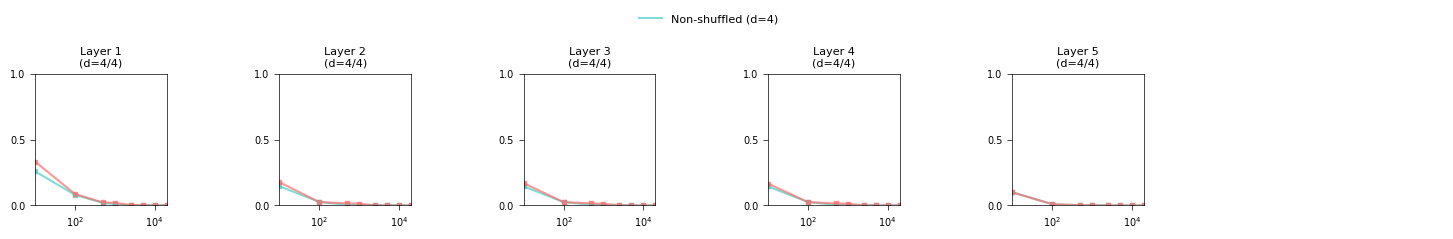

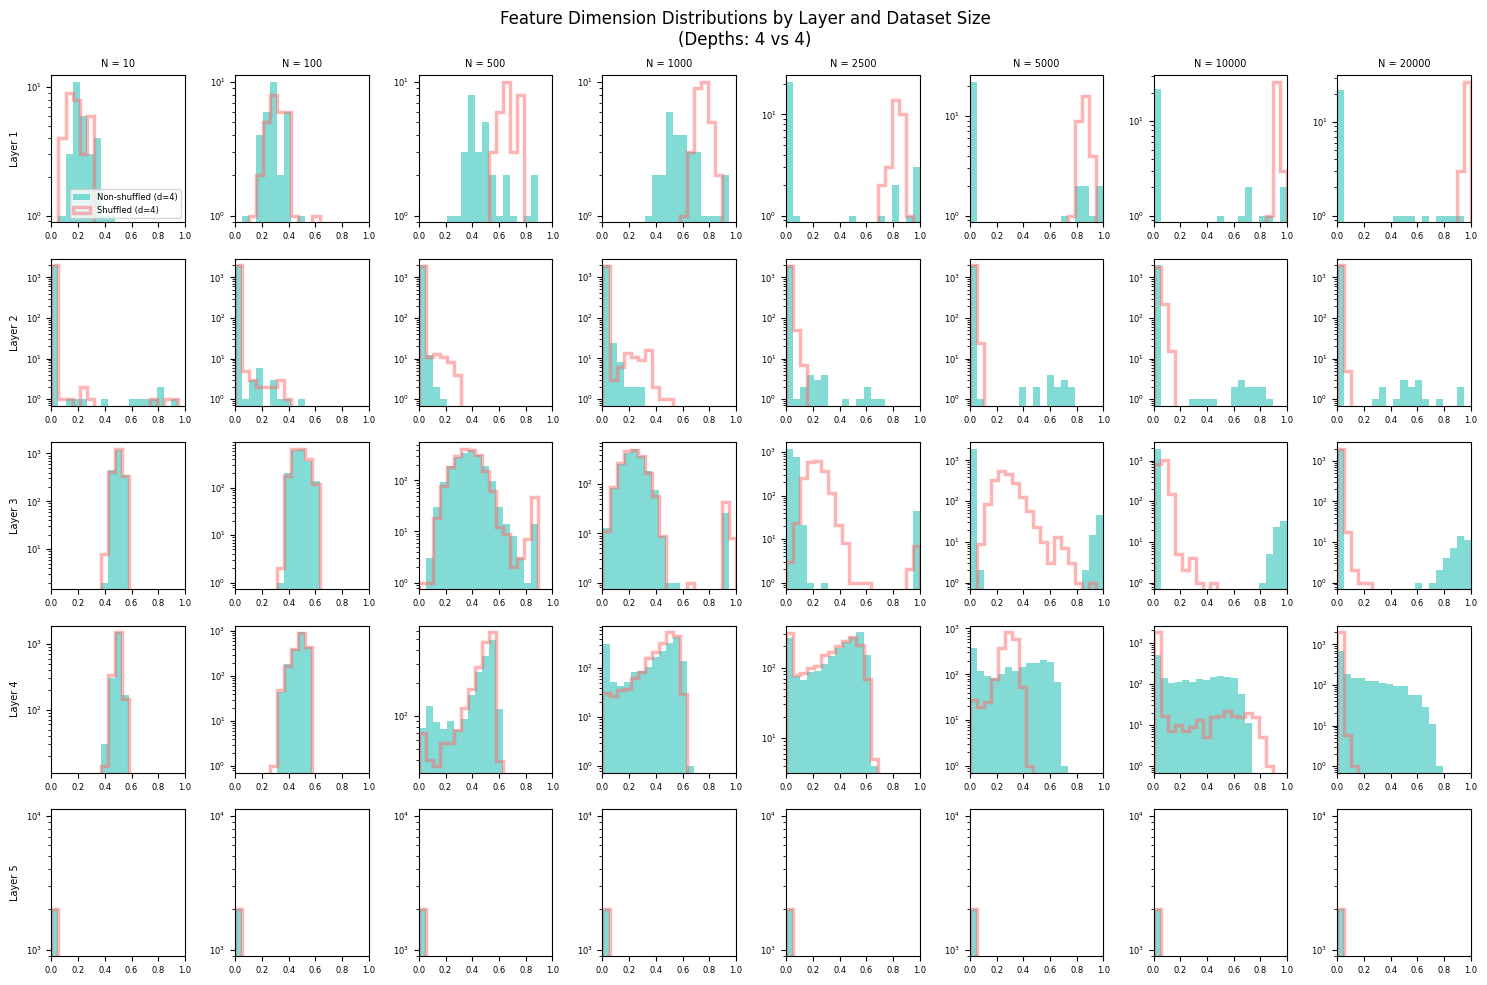

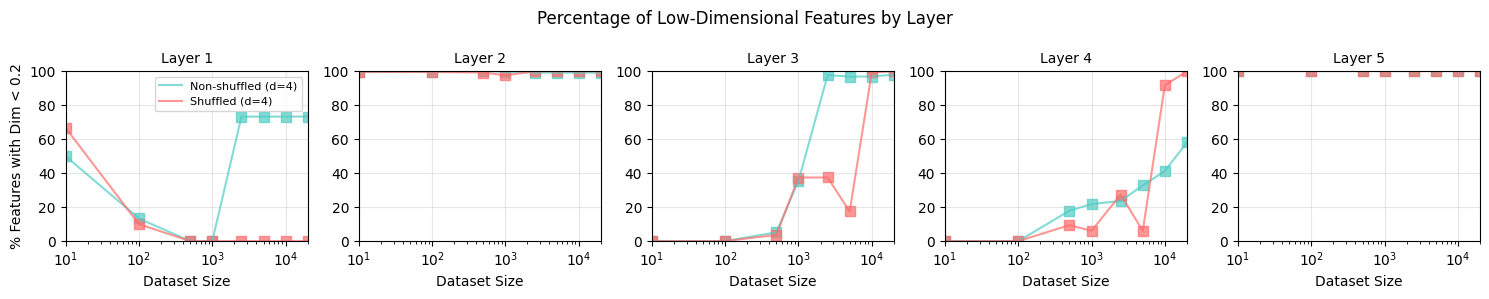

In [2]:
import torch
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List

class DeepNN(torch.nn.Module):
    def __init__(self, d: int, hidden_size: int, depth: int, mode: str = 'standard', gamma: float = 1.0):
        super().__init__()
        torch.set_default_dtype(torch.float32)
        self.gamma = gamma
        self.mode = mode
        self.depth = depth
        self.hidden_size = hidden_size
        self.input_dim = d
        
        layers = []
        prev_dim = d
        
        for layer_idx in range(depth):
            linear = torch.nn.Linear(prev_dim, hidden_size)
            if mode == 'standard':
                torch.nn.init.xavier_uniform_(linear.weight)
                torch.nn.init.zeros_(linear.bias)
            layers.extend([linear, torch.nn.ReLU()])
            prev_dim = hidden_size
        
        final_layer = torch.nn.Linear(prev_dim, 1)
        if mode == 'standard':
            torch.nn.init.xavier_uniform_(final_layer.weight)
        torch.nn.init.zeros_(final_layer.bias)
        layers.append(final_layer)
        
        self.network = torch.nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x).squeeze() / float(self.gamma)

def load_experiment_data(results_dir: str, timestamp: str) -> Tuple[List[Dict], Dict]:
    """Load experiment results and hyperparameters from the given directory"""
    hyperparams_path = os.path.join(results_dir, f'hyperparameters_{timestamp}.json')
    with open(hyperparams_path, 'r') as f:
        hyperparams = json.load(f)
    
    results_path = os.path.join(results_dir, f'final_results_{timestamp}.json')
    with open(results_path, 'r') as f:
        results = json.load(f)
    
    return results, hyperparams

def load_model_and_data(data_dir: str, results_dir: str, result: Dict, timestamp: str) -> Tuple[torch.nn.Module, torch.Tensor, torch.Tensor]:
    """Load the model and its corresponding training data"""
    hyperparams_path = os.path.join(results_dir, f'hyperparameters_{timestamp}.json')
    with open(hyperparams_path, 'r') as f:
        hyperparams = json.load(f)
    input_dim = hyperparams['d']
    
    hidden_size = result['hidden_size']
    depth = result['depth']
    n_train = result['n_train']
    lr = result['learning_rate']
    mode = result.get('mode', 'standard')
    shuffled = result.get('shuffled', False)
    rank = result.get('worker_rank', 0)
    gamma = result.get('gamma', 1.0)
    
    model_prefix = f'h{hidden_size}_d{depth}_n{n_train}_lr{lr}_g{gamma}_{mode}'
    if shuffled:
        model_prefix += '_shuffled'
    
    model_path = os.path.join(results_dir, f'final_model_{model_prefix}_{timestamp}_rank{rank}.pt')
    model = DeepNN(input_dim, hidden_size, depth, mode=mode, gamma=gamma)
    model.load_state_dict(torch.load(model_path))
    
    train_dataset_path = os.path.join(results_dir, f'train_dataset_{model_prefix}_{timestamp}_rank{rank}.pt')
    train_data = torch.load(train_dataset_path)
    
    X_train = train_data['X']
    y_train = train_data['y']
    
    device = next(model.parameters()).device
    model = model.to(device)
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    
    return model, X_train, y_train

def compute_anthropic_dimensionality(hidden: torch.Tensor, features: torch.Tensor) -> Tuple[float, float, float, float, torch.Tensor]:
    """Compute Anthropic's dimensionality metrics"""
    with torch.no_grad():
        # Sample dimensionality
        hidden_norms = torch.norm(hidden, dim=1, keepdim=True)
        normalized_hidden = hidden / (hidden_norms + 1e-8)
        hidden_dots = normalized_hidden @ hidden.T
        hidden_dots_squared = hidden_dots ** 2
        sample_denominator = torch.sum(hidden_dots_squared, dim=1)
        sample_numerator = torch.sum(hidden * hidden, dim=1)
        sample_dims = sample_numerator / (sample_denominator + 1e-8)
        
        sample_mean = float(torch.mean(sample_dims))
        sample_std = float(torch.std(sample_dims))

        # Feature dimensionality
        feature_norms = torch.norm(features, dim=0, keepdim=True)
        normalized_features = features / (feature_norms + 1e-8)
        feature_dots = normalized_features.T @ features
        feature_dots_squared = feature_dots ** 2
        feature_denominator = torch.sum(feature_dots_squared, dim=1)
        feature_numerator = torch.sum(features * features, dim=0)
        feature_dims = feature_numerator / (feature_denominator + 1e-8)
        
        feature_mean = float(torch.mean(feature_dims))
        feature_std = float(torch.std(feature_dims))

        return sample_mean, sample_std, feature_mean, feature_std, feature_dims
def analyze_by_dataset_size(results: List[Dict], hyperparams: Dict, data_dir: str, results_dir: str, 
                         timestamp: str, target_lr=None, target_hidden_size=None, target_depth=None):
    """Analyze metrics for specific model configuration"""
    # Filter results by learning rate and model architecture
    filtered_results = results
    if target_lr is not None:
        filtered_results = [r for r in filtered_results if r['learning_rate'] == target_lr]
    if target_hidden_size is not None:
        filtered_results = [r for r in filtered_results if r['hidden_size'] == target_hidden_size]
    if target_depth is not None:
        filtered_results = [r for r in filtered_results if r['depth'] == target_depth]
    
    # Sort by dataset size
    sorted_results = sorted(filtered_results, key=lambda x: x['n_train'])
    
    if not sorted_results:
        raise ValueError(f"No results found for specified configuration: lr={target_lr}, hidden_size={target_hidden_size}, depth={target_depth}")
    
    metrics = {
        'n_train': [],
        'layers': [],
        'raw_feature_dims': []  # Add storage for raw feature dimensions
    }
    
    for result in sorted_results:
        print(f"Processing result: n_train={result['n_train']}, "
              f"hidden_size={result['hidden_size']}, depth={result['depth']}, "
              f"lr={result['learning_rate']}, "
              f"shuffled={result.get('shuffled', False)}")
        
        model, X_train, y_train = load_model_and_data(data_dir, results_dir, result, timestamp)
        layer_metrics = analyze_dimensionality_by_layer(model, X_train)
        
        metrics['n_train'].append(result['n_train'])
        metrics['layers'].append(layer_metrics)
        
        # Store raw feature dimensions for each layer
        raw_dims = []
        for layer_metric in layer_metrics:
            raw_dims.append(layer_metric['anthropic']['feature_dims_raw'])
        metrics['raw_feature_dims'].append(raw_dims)
    
    return metrics



def analyze_dimensionality_by_layer(model: torch.nn.Module, X: torch.Tensor) -> Dict:
    """Compute dimensionality metrics for each layer"""
    layer_metrics = []
    current_activation = X
    
    with torch.no_grad():
        for i, layer in enumerate(model.network):
            if hasattr(layer, 'weight'):
                features = layer.weight.data
            else:
                continue
            
            current_activation = layer(current_activation)
            
            sample_mean, sample_std, feature_mean, feature_std, feature_dims = compute_anthropic_dimensionality(
                current_activation, features)
            
            layer_metrics.append({
                'layer': i,
                'anthropic': {
                    'sample_dim': sample_mean,
                    'sample_dim_std': sample_std,
                    'feature_dim': feature_mean,
                    'feature_dim_std': feature_std,
                    'feature_dims_raw': feature_dims.cpu().numpy()
                }
            })
    
    return layer_metrics

def extract_metrics_array(metrics: Dict) -> Tuple[np.ndarray, List[List[np.ndarray]], List[List[float]]]:
    """Extract metrics into numpy array and list of raw feature dimension arrays with better dimension handling"""
    if not metrics['layers']:
        raise ValueError("No metrics data found")
        
    n_layers = len(metrics['layers'][0])
    n_datapoints = len(metrics['layers'])
    n_dim_types = 4
    
    result = np.zeros((n_dim_types, n_layers, n_datapoints))
    
    # Process regular metrics
    for dp_idx, layer_metrics in enumerate(metrics['layers']):
        for layer_idx in range(n_layers):
            result[0, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['sample_dim']
            result[1, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['sample_dim_std']
            result[2, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['feature_dim']
            result[3, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['feature_dim_std']
    
    # Process raw feature dimensions - now properly structured as [dataset][layer]
    raw_feature_dims = []
    for dp_idx in range(n_datapoints):
        layer_dims = []
        for layer_idx in range(n_layers):
            dims = metrics['layers'][dp_idx][layer_idx]['anthropic']['feature_dims_raw']
            layer_dims.append(dims)
        raw_feature_dims.append(layer_dims)
    
    # Calculate percentage of feature dimensions below threshold per layer
    low_dim_percentages = [[] for _ in range(n_layers)]
    for layer_idx in range(n_layers):
        for dp_idx in range(n_datapoints):
            feat_dims = raw_feature_dims[dp_idx][layer_idx]
            low_dims = np.sum(feat_dims < 0.2)
            total_dims = len(feat_dims)
            percentage = (low_dims / total_dims) * 100 if total_dims > 0 else 0
            low_dim_percentages[layer_idx].append(percentage)
    
    return result, raw_feature_dims, low_dim_percentages


def plot_dimensionality_comparison(metrics1, metrics2, raw_dims1, raw_dims2, 
                               low_dim_pct1, low_dim_pct2,
                               label1="Model 1", label2="Model 2",
                               sample_figsize=(15.0, 2.0),
                               hist_figsize=(15, 10),
                               low_dim_figsize=(15, 3),
                               depth1=None, depth2=None):
    """Plot dimensionality analysis comparison between two models with safer array handling"""
    # Get dataset sizes from the metrics
    dataset_sizes = metrics1['n_train']
    n_layers = len(metrics1['layers'][0])
    n_datasets = len(dataset_sizes)
    
    print(f"Debug info:")
    print(f"Number of layers: {n_layers}")
    print(f"Number of datasets: {n_datasets}")
    print(f"Dataset sizes: {dataset_sizes}")
    print(f"Raw dims1 structure: {len(raw_dims1)} x {len(raw_dims1[0]) if raw_dims1 else 0}")
    print(f"Raw dims2 structure: {len(raw_dims2)} x {len(raw_dims2[0]) if raw_dims2 else 0}")
    
    # Sample Dimensionality Plot
    fig1, axs1 = plt.subplots(1, n_layers + 1, figsize=sample_figsize)
    fig1.subplots_adjust(wspace=0.01)
    
    sample_dim1 = metrics1_arr[0]
    sample_dim2 = metrics2_arr[0]
    
    # Set up consistent y-axis limits
    y_min = 0.0
    y_max = 1.0
    
    for layer in range(n_layers):
        ax = axs1[layer]
        
        ax.plot(dataset_sizes, sample_dim1[layer], color='#4ECDC4', alpha=0.7, linewidth=1.5)
        ax.plot(dataset_sizes, sample_dim2[layer], color='#FF6B6B', alpha=0.7, linewidth=1.5)
        
        ax.scatter(dataset_sizes, sample_dim1[layer], color='#4ECDC4', marker='s', s=10, alpha=0.7)
        ax.scatter(dataset_sizes, sample_dim2[layer], color='#FF6B6B', marker='s', s=10, alpha=0.7)
        
        layer_title = f'Layer {layer+1}'
        if depth1 is not None and depth2 is not None:
            layer_title += f'\n(d={depth1}/{depth2})'
        ax.set_title(layer_title, fontsize=8)
        
        ax.set_ylim(y_min, y_max)
        ax.set_yticks([0.0, 0.5, 1.0])
        ax.set_yticklabels(['0.0', '0.5', '1.0'], fontsize=7)
        
        ax.set_xscale('log')
        ax.set_xlim(10, 2e4)
        ax.set_xticks([1e2, 1e4])
        ax.set_xticklabels(['$10^2$', '$10^4$'], fontsize=7)
        
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(0.5)
            
        ax.tick_params(width=0.5)
        ax.set_box_aspect(1)
    
    axs1[-1].axis('off')
    
    if depth1 is not None and depth2 is not None:
        label1 = f"{label1} (d={depth1})"
        label2 = f"{label2} (d={depth2})"
    
    lines = axs1[0].get_lines()[::2]
    fig1.legend(lines, [label1, label2],
               loc='upper center',
               bbox_to_anchor=(0.5, 1.2),
               ncol=2,
               fontsize=8,
               frameon=False)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    
    # Feature Dimensionality Histograms with safer array handling
    fig2, axs2 = plt.subplots(n_layers, n_datasets, figsize=hist_figsize)
    title = 'Feature Dimension Distributions by Layer and Dataset Size'
    if depth1 is not None and depth2 is not None:
        title += f'\n(Depths: {depth1} vs {depth2})'
    fig2.suptitle(title, fontsize=12)
    
    x_min, x_max = 0.0, 1.0
    bins = np.linspace(x_min, x_max, 20)  # Reduced number of bins for thicker bars
    
    # Ensure axs2 is always 2D
    if n_layers == 1:
        axs2 = np.array([axs2])
    if n_datasets == 1:
        axs2 = np.array([axs2]).T
    
    for layer in range(n_layers):
        for idx in range(n_datasets):
            try:
                ax = axs2[layer, idx]
                
                # Safely access raw dimensions
                dims1 = raw_dims1[idx][layer] if idx < len(raw_dims1) and layer < len(raw_dims1[idx]) else []
                dims2 = raw_dims2[idx][layer] if idx < len(raw_dims2) and layer < len(raw_dims2[idx]) else []
                
                if len(dims1) > 0:
                    counts1, bins1, patches1 = ax.hist(dims1, bins=bins, alpha=0.7,  # Increased alpha
                                                     color='#4ECDC4', label=label1, 
                                                     histtype='stepfilled',
                                                     linewidth=2.0)  # Increased line width
                if len(dims2) > 0:
                    counts2, bins2, patches2 = ax.hist(dims2, bins=bins, alpha=0.5,
                                                     color='#FF6B6B', label=label2, 
                                                     histtype='step',
                                                     linewidth=2.5,  # Increased line width
                                                     edgecolor='#FF6B6B')
                
                if (len(dims1) > 0 and np.max(counts1) > 0) or (len(dims2) > 0 and np.max(counts2) > 0):
                    ax.set_yscale('log')
                
                ax.set_xlim(x_min, x_max)
                
                if layer == 0:
                    ax.set_title(f'N = {dataset_sizes[idx]}', fontsize=7)
                if idx == 0:
                    ax.set_ylabel(f'Layer {layer+1}', fontsize=7)
                
                ax.tick_params(labelsize=6)
                if layer == 0 and idx == 0:
                    ax.legend(fontsize=6)
                    
            except Exception as e:
                print(f"Error plotting histogram for layer {layer}, dataset {idx}: {str(e)}")
    
    plt.tight_layout()
    
    # Plot low-dimensional feature percentage per layer with safer array handling
    fig3, axs3 = plt.subplots(1, n_layers, figsize=low_dim_figsize)
    fig3.suptitle('Percentage of Low-Dimensional Features by Layer', fontsize=12)
    
    # Ensure axs3 is an array
    axs3 = np.atleast_1d(axs3)
    
    for layer in range(n_layers):
        ax = axs3[layer] if n_layers > 1 else axs3[0]
        
        try:
            ax.plot(dataset_sizes, low_dim_pct1[layer], color='#4ECDC4', alpha=0.7, linewidth=1.5, label=label1)
            ax.plot(dataset_sizes, low_dim_pct2[layer], color='#FF6B6B', alpha=0.7, linewidth=1.5, label=label2)
            
            ax.scatter(dataset_sizes, low_dim_pct1[layer], color='#4ECDC4', marker='s', s=50, alpha=0.7)
            ax.scatter(dataset_sizes, low_dim_pct2[layer], color='#FF6B6B', marker='s', s=50, alpha=0.7)
        except Exception as e:
            print(f"Error plotting low-dim percentages for layer {layer}: {str(e)}")
        
        ax.set_xscale('log')
        ax.set_xlim(10, 2e4)
        ax.set_ylim(0, 100)
        
        ax.set_xlabel('Dataset Size', fontsize=10)
        if layer == 0:
            ax.set_ylabel('% Features with Dim < 0.2', fontsize=10)
        
        ax.set_title(f'Layer {layer+1}', fontsize=10)
        if layer == 0:
            ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()



# Add this debug function
def print_metrics_info(metrics, raw_dims, label):
    print(f"\nDebug info for {label}:")
    print(f"Number of training sizes: {len(metrics['n_train'])}")
    print(f"Training sizes: {metrics['n_train']}")
    print(f"Number of layers: {len(metrics['layers'][0])}")
    print(f"Raw dimensions structure:")
    print(f"- Number of datasets: {len(raw_dims)}")
    if raw_dims:
        print(f"- Dimensions per layer: {[len(layer_dims) for layer_dims in raw_dims[0]]}")
    
# Before plotting, add debug info
#print_metrics_info(metrics1, raw_dims1, "Model 1 (Non-shuffled)")
#print_metrics_info(metrics2, raw_dims2, "Model 2 (Shuffled)")

# Example usage
results_dir1 = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_anthro_false_mup_lr0005_gamma_001_modelsaved"
results_dir2 = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_anthro_true_mup_lr0005_gamma_001_modelsaved"
timestamp1 = "20250125_152950"  # First model timestamp
timestamp2 = "20250125_152857"  # Second model timestamp
hidden_size = 2000  # The hidden size to analyze
depth = 4 # The depth to analyze
target_lr = 0.005  # The learning rate used in training
gamma = 0.01  # The gamma value used in training
dataset_sizes = [10, 100, 500, 1000, 5000, 10000, 20000]  # The actual dataset sizes used
# Example usage with added debugging
print("Loading and analyzing first model (non-shuffled)...")
results1, hyperparams1 = load_experiment_data(results_dir1, timestamp1)
metrics1 = analyze_by_dataset_size(
    results1, 
    hyperparams1, 
    results_dir1, 
    results_dir1, 
    timestamp1, 
    target_lr=target_lr,
    target_hidden_size=hidden_size,
    target_depth=depth
)

print("\nLoading and analyzing second model (shuffled)...")
results2, hyperparams2 = load_experiment_data(results_dir2, timestamp2)
metrics2 = analyze_by_dataset_size(
    results2, 
    hyperparams2, 
    results_dir2, 
    results_dir2, 
    timestamp2, 
    target_lr=target_lr,
    target_hidden_size=hidden_size,
    target_depth=depth
)

# Extract arrays with debugging information
print("\nExtracting metrics arrays...")
metrics1_arr, raw_dims1, low_dim_pct1 = extract_metrics_array(metrics1)
metrics2_arr, raw_dims2, low_dim_pct2 = extract_metrics_array(metrics2)

# Additional debugging prints
print(f"\nMetrics shapes:")
print(f"metrics1_arr shape: {metrics1_arr.shape}")
print(f"metrics2_arr shape: {metrics2_arr.shape}")
print(f"Number of dataset sizes: {len(metrics1['n_train'])}")
print(f"Dataset sizes in first model: {metrics1['n_train']}")
print(f"Dataset sizes in second model: {metrics2['n_train']}")

# Plot with additional debugging information
print("\nPlotting comparison...")
plot_dimensionality_comparison(
    metrics1, 
    metrics2, 
    raw_dims1, 
    raw_dims2, 
    low_dim_pct1,
    low_dim_pct2,
    label1="Non-shuffled",
    label2="Shuffled",
    depth1=depth,
    depth2=depth
)

Loading and analyzing first model (non-shuffled)...
Processing result: n_train=10, hidden_size=400, depth=4, lr=0.005, shuffled=False


/tmp/ipykernel_1958516/3097785729.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
/tmp/ipykernel_1958516/3097785729.py:77:

Processing result: n_train=100, hidden_size=400, depth=4, lr=0.005, shuffled=False
Processing result: n_train=500, hidden_size=400, depth=4, lr=0.005, shuffled=False
Processing result: n_train=1000, hidden_size=400, depth=4, lr=0.005, shuffled=False
Processing result: n_train=2500, hidden_size=400, depth=4, lr=0.005, shuffled=False
Processing result: n_train=5000, hidden_size=400, depth=4, lr=0.005, shuffled=False
Processing result: n_train=10000, hidden_size=400, depth=4, lr=0.005, shuffled=False
Processing result: n_train=20000, hidden_size=400, depth=4, lr=0.005, shuffled=False

Loading and analyzing second model (shuffled)...
Processing result: n_train=10, hidden_size=400, depth=4, lr=0.005, shuffled=True
Processing result: n_train=100, hidden_size=400, depth=4, lr=0.005, shuffled=True
Processing result: n_train=500, hidden_size=400, depth=4, lr=0.005, shuffled=True
Processing result: n_train=1000, hidden_size=400, depth=4, lr=0.005, shuffled=True
Processing result: n_train=2500, h

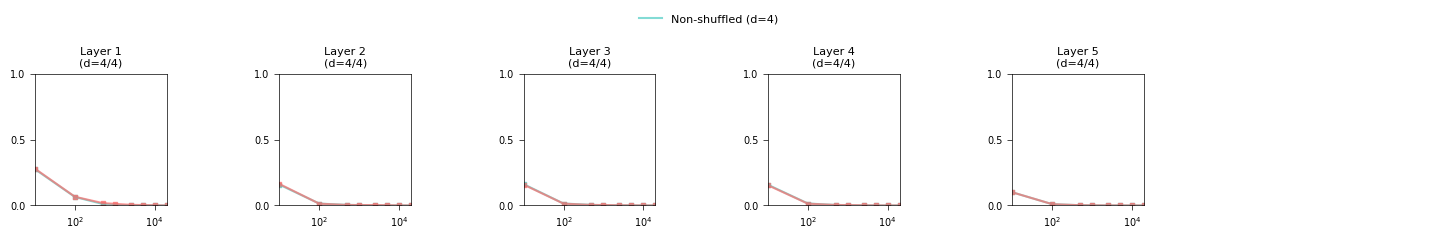

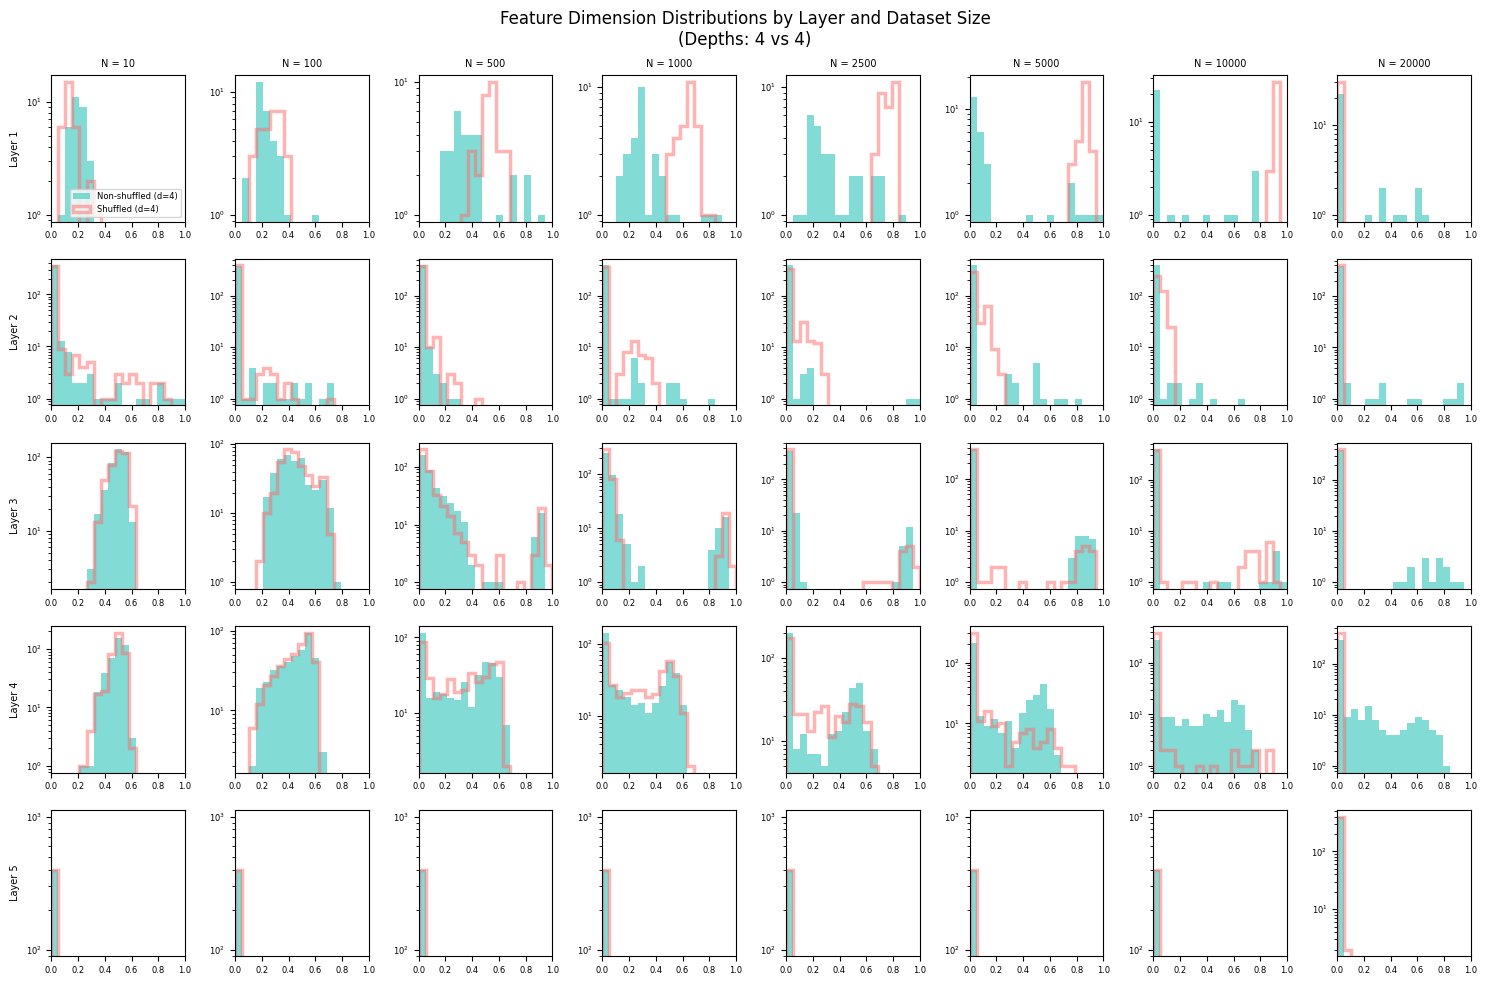

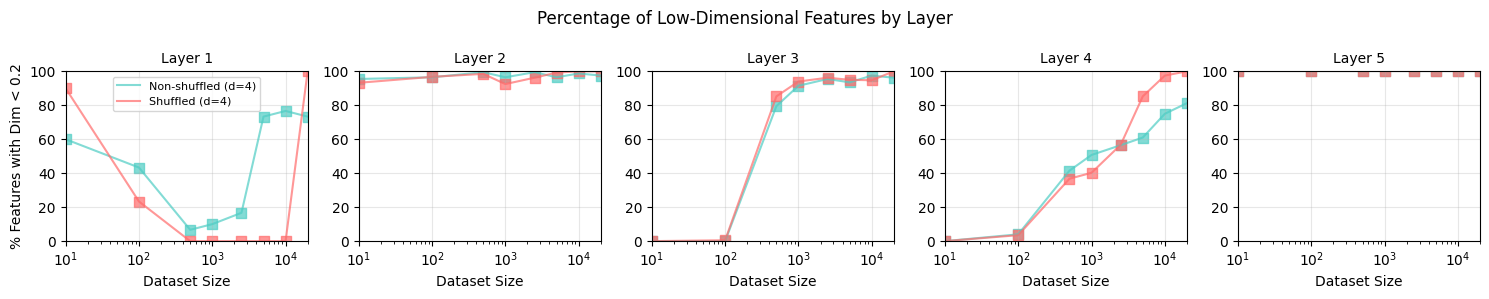

In [4]:
import torch
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List

class DeepNN(torch.nn.Module):
    def __init__(self, d: int, hidden_size: int, depth: int, mode: str = 'standard', gamma: float = 1.0):
        super().__init__()
        torch.set_default_dtype(torch.float32)
        self.gamma = gamma
        self.mode = mode
        self.depth = depth
        self.hidden_size = hidden_size
        self.input_dim = d
        
        layers = []
        prev_dim = d
        
        for layer_idx in range(depth):
            linear = torch.nn.Linear(prev_dim, hidden_size)
            if mode == 'standard':
                torch.nn.init.xavier_uniform_(linear.weight)
                torch.nn.init.zeros_(linear.bias)
            layers.extend([linear, torch.nn.ReLU()])
            prev_dim = hidden_size
        
        final_layer = torch.nn.Linear(prev_dim, 1)
        if mode == 'standard':
            torch.nn.init.xavier_uniform_(final_layer.weight)
        torch.nn.init.zeros_(final_layer.bias)
        layers.append(final_layer)
        
        self.network = torch.nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x).squeeze() / float(self.gamma)

def load_experiment_data(results_dir: str, timestamp: str) -> Tuple[List[Dict], Dict]:
    """Load experiment results and hyperparameters from the given directory"""
    hyperparams_path = os.path.join(results_dir, f'hyperparameters_{timestamp}.json')
    with open(hyperparams_path, 'r') as f:
        hyperparams = json.load(f)
    
    results_path = os.path.join(results_dir, f'final_results_{timestamp}.json')
    with open(results_path, 'r') as f:
        results = json.load(f)
    
    return results, hyperparams

def load_model_and_data(data_dir: str, results_dir: str, result: Dict, timestamp: str) -> Tuple[torch.nn.Module, torch.Tensor, torch.Tensor]:
    """Load the model and its corresponding training data"""
    hyperparams_path = os.path.join(results_dir, f'hyperparameters_{timestamp}.json')
    with open(hyperparams_path, 'r') as f:
        hyperparams = json.load(f)
    input_dim = hyperparams['d']
    
    hidden_size = result['hidden_size']
    depth = result['depth']
    n_train = result['n_train']
    lr = result['learning_rate']
    mode = result.get('mode', 'standard')
    shuffled = result.get('shuffled', False)
    rank = result.get('worker_rank', 0)
    gamma = result.get('gamma', 1.0)
    
    model_prefix = f'h{hidden_size}_d{depth}_n{n_train}_lr{lr}_g{gamma}_{mode}'
    if shuffled:
        model_prefix += '_shuffled'
    
    model_path = os.path.join(results_dir, f'final_model_{model_prefix}_{timestamp}_rank{rank}.pt')
    model = DeepNN(input_dim, hidden_size, depth, mode=mode, gamma=gamma)
    model.load_state_dict(torch.load(model_path))
    
    train_dataset_path = os.path.join(results_dir, f'train_dataset_{model_prefix}_{timestamp}_rank{rank}.pt')
    train_data = torch.load(train_dataset_path)
    
    X_train = train_data['X']
    y_train = train_data['y']
    
    device = next(model.parameters()).device
    model = model.to(device)
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    
    return model, X_train, y_train

def compute_anthropic_dimensionality(hidden: torch.Tensor, features: torch.Tensor) -> Tuple[float, float, float, float, torch.Tensor]:
    """Compute Anthropic's dimensionality metrics"""
    with torch.no_grad():
        # Sample dimensionality
        hidden_norms = torch.norm(hidden, dim=1, keepdim=True)
        normalized_hidden = hidden / (hidden_norms + 1e-8)
        hidden_dots = normalized_hidden @ hidden.T
        hidden_dots_squared = hidden_dots ** 2
        sample_denominator = torch.sum(hidden_dots_squared, dim=1)
        sample_numerator = torch.sum(hidden * hidden, dim=1)
        sample_dims = sample_numerator / (sample_denominator + 1e-8)
        
        sample_mean = float(torch.mean(sample_dims))
        sample_std = float(torch.std(sample_dims))

        # Feature dimensionality
        feature_norms = torch.norm(features, dim=0, keepdim=True)
        normalized_features = features / (feature_norms + 1e-8)
        feature_dots = normalized_features.T @ features
        feature_dots_squared = feature_dots ** 2
        feature_denominator = torch.sum(feature_dots_squared, dim=1)
        feature_numerator = torch.sum(features * features, dim=0)
        feature_dims = feature_numerator / (feature_denominator + 1e-8)
        
        feature_mean = float(torch.mean(feature_dims))
        feature_std = float(torch.std(feature_dims))

        return sample_mean, sample_std, feature_mean, feature_std, feature_dims
def analyze_by_dataset_size(results: List[Dict], hyperparams: Dict, data_dir: str, results_dir: str, 
                         timestamp: str, target_lr=None, target_hidden_size=None, target_depth=None):
    """Analyze metrics for specific model configuration"""
    # Filter results by learning rate and model architecture
    filtered_results = results
    if target_lr is not None:
        filtered_results = [r for r in filtered_results if r['learning_rate'] == target_lr]
    if target_hidden_size is not None:
        filtered_results = [r for r in filtered_results if r['hidden_size'] == target_hidden_size]
    if target_depth is not None:
        filtered_results = [r for r in filtered_results if r['depth'] == target_depth]
    
    # Sort by dataset size
    sorted_results = sorted(filtered_results, key=lambda x: x['n_train'])
    
    if not sorted_results:
        raise ValueError(f"No results found for specified configuration: lr={target_lr}, hidden_size={target_hidden_size}, depth={target_depth}")
    
    metrics = {
        'n_train': [],
        'layers': [],
        'raw_feature_dims': []  # Add storage for raw feature dimensions
    }
    
    for result in sorted_results:
        print(f"Processing result: n_train={result['n_train']}, "
              f"hidden_size={result['hidden_size']}, depth={result['depth']}, "
              f"lr={result['learning_rate']}, "
              f"shuffled={result.get('shuffled', False)}")
        
        model, X_train, y_train = load_model_and_data(data_dir, results_dir, result, timestamp)
        layer_metrics = analyze_dimensionality_by_layer(model, X_train)
        
        metrics['n_train'].append(result['n_train'])
        metrics['layers'].append(layer_metrics)
        
        # Store raw feature dimensions for each layer
        raw_dims = []
        for layer_metric in layer_metrics:
            raw_dims.append(layer_metric['anthropic']['feature_dims_raw'])
        metrics['raw_feature_dims'].append(raw_dims)
    
    return metrics

def extract_metrics_array(metrics: Dict) -> Tuple[np.ndarray, List[List[np.ndarray]], List[List[float]]]:
    """Extract metrics into numpy array and list of raw feature dimension arrays with better dimension handling"""
    if not metrics['layers']:
        raise ValueError("No metrics data found")
        
    n_layers = len(metrics['layers'][0])
    n_datapoints = len(metrics['layers'])
    n_dim_types = 4
    
    result = np.zeros((n_dim_types, n_layers, n_datapoints))
    
    # Process regular metrics
    for dp_idx, layer_metrics in enumerate(metrics['layers']):
        for layer_idx in range(n_layers):
            result[0, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['sample_dim']
            result[1, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['sample_dim_std']
            result[2, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['feature_dim']
            result[3, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['feature_dim_std']
    
    # Process raw feature dimensions - now properly structured as [dataset][layer]
    raw_feature_dims = []
    for dp_idx in range(n_datapoints):
        layer_dims = []
        for layer_idx in range(n_layers):
            dims = metrics['layers'][dp_idx][layer_idx]['anthropic']['feature_dims_raw']
            layer_dims.append(dims)
        raw_feature_dims.append(layer_dims)
    
    # Calculate percentage of feature dimensions below threshold per layer
    low_dim_percentages = [[] for _ in range(n_layers)]
    for layer_idx in range(n_layers):
        for dp_idx in range(n_datapoints):
            feat_dims = raw_feature_dims[dp_idx][layer_idx]
            low_dims = np.sum(feat_dims < 0.2)
            total_dims = len(feat_dims)
            percentage = (low_dims / total_dims) * 100 if total_dims > 0 else 0
            low_dim_percentages[layer_idx].append(percentage)
    
    return result, raw_feature_dims, low_dim_percentages



def analyze_dimensionality_by_layer(model: torch.nn.Module, X: torch.Tensor) -> Dict:
    """Compute dimensionality metrics for each layer"""
    layer_metrics = []
    current_activation = X
    
    with torch.no_grad():
        for i, layer in enumerate(model.network):
            if hasattr(layer, 'weight'):
                features = layer.weight.data
            else:
                continue
            
            current_activation = layer(current_activation)
            
            sample_mean, sample_std, feature_mean, feature_std, feature_dims = compute_anthropic_dimensionality(
                current_activation, features)
            
            layer_metrics.append({
                'layer': i,
                'anthropic': {
                    'sample_dim': sample_mean,
                    'sample_dim_std': sample_std,
                    'feature_dim': feature_mean,
                    'feature_dim_std': feature_std,
                    'feature_dims_raw': feature_dims.cpu().numpy()
                }
            })
    
    return layer_metrics

def plot_dimensionality_comparison(metrics1, metrics2, raw_dims1, raw_dims2, 
                               low_dim_pct1, low_dim_pct2,
                               label1="Model 1", label2="Model 2",
                               sample_figsize=(15.0, 2.0),
                               hist_figsize=(15, 10),
                               low_dim_figsize=(15, 3),
                               depth1=None, depth2=None):
    """Plot dimensionality analysis comparison between two models with safer array handling"""
    # Get dataset sizes from the metrics
    dataset_sizes = metrics1['n_train']
    n_layers = len(metrics1['layers'][0])
    n_datasets = len(dataset_sizes)
    
    print(f"Debug info:")
    print(f"Number of layers: {n_layers}")
    print(f"Number of datasets: {n_datasets}")
    print(f"Dataset sizes: {dataset_sizes}")
    print(f"Raw dims1 structure: {len(raw_dims1)} x {len(raw_dims1[0]) if raw_dims1 else 0}")
    print(f"Raw dims2 structure: {len(raw_dims2)} x {len(raw_dims2[0]) if raw_dims2 else 0}")
    
    # Sample Dimensionality Plot
    fig1, axs1 = plt.subplots(1, n_layers + 1, figsize=sample_figsize)
    fig1.subplots_adjust(wspace=0.01)
    
    sample_dim1 = metrics1_arr[0]
    sample_dim2 = metrics2_arr[0]
    
    # Set up consistent y-axis limits
    y_min = 0.0
    y_max = 1.0
    
    for layer in range(n_layers):
        ax = axs1[layer]
        
        ax.plot(dataset_sizes, sample_dim1[layer], color='#4ECDC4', alpha=0.7, linewidth=1.5)
        ax.plot(dataset_sizes, sample_dim2[layer], color='#FF6B6B', alpha=0.7, linewidth=1.5)
        
        ax.scatter(dataset_sizes, sample_dim1[layer], color='#4ECDC4', marker='s', s=10, alpha=0.7)
        ax.scatter(dataset_sizes, sample_dim2[layer], color='#FF6B6B', marker='s', s=10, alpha=0.7)
        
        layer_title = f'Layer {layer+1}'
        if depth1 is not None and depth2 is not None:
            layer_title += f'\n(d={depth1}/{depth2})'
        ax.set_title(layer_title, fontsize=8)
        
        ax.set_ylim(y_min, y_max)
        ax.set_yticks([0.0, 0.5, 1.0])
        ax.set_yticklabels(['0.0', '0.5', '1.0'], fontsize=7)
        
        ax.set_xscale('log')
        ax.set_xlim(10, 2e4)
        ax.set_xticks([1e2, 1e4])
        ax.set_xticklabels(['$10^2$', '$10^4$'], fontsize=7)
        
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(0.5)
            
        ax.tick_params(width=0.5)
        ax.set_box_aspect(1)
    
    axs1[-1].axis('off')
    
    if depth1 is not None and depth2 is not None:
        label1 = f"{label1} (d={depth1})"
        label2 = f"{label2} (d={depth2})"
    
    lines = axs1[0].get_lines()[::2]
    fig1.legend(lines, [label1, label2],
               loc='upper center',
               bbox_to_anchor=(0.5, 1.2),
               ncol=2,
               fontsize=8,
               frameon=False)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    
    # Feature Dimensionality Histograms with safer array handling
    fig2, axs2 = plt.subplots(n_layers, n_datasets, figsize=hist_figsize)
    title = 'Feature Dimension Distributions by Layer and Dataset Size'
    if depth1 is not None and depth2 is not None:
        title += f'\n(Depths: {depth1} vs {depth2})'
    fig2.suptitle(title, fontsize=12)
    
    x_min, x_max = 0.0, 1.0
    bins = np.linspace(x_min, x_max, 20)  # Reduced number of bins for thicker bars
    
    # Ensure axs2 is always 2D
    if n_layers == 1:
        axs2 = np.array([axs2])
    if n_datasets == 1:
        axs2 = np.array([axs2]).T
    
    for layer in range(n_layers):
        for idx in range(n_datasets):
            try:
                ax = axs2[layer, idx]
                
                # Safely access raw dimensions
                dims1 = raw_dims1[idx][layer] if idx < len(raw_dims1) and layer < len(raw_dims1[idx]) else []
                dims2 = raw_dims2[idx][layer] if idx < len(raw_dims2) and layer < len(raw_dims2[idx]) else []
                
                if len(dims1) > 0:
                    counts1, bins1, patches1 = ax.hist(dims1, bins=bins, alpha=0.7,  # Increased alpha
                                                     color='#4ECDC4', label=label1, 
                                                     histtype='stepfilled',
                                                     linewidth=2.0)  # Increased line width
                if len(dims2) > 0:
                    counts2, bins2, patches2 = ax.hist(dims2, bins=bins, alpha=0.5,
                                                     color='#FF6B6B', label=label2, 
                                                     histtype='step',
                                                     linewidth=2.5,  # Increased line width
                                                     edgecolor='#FF6B6B')
                
                if (len(dims1) > 0 and np.max(counts1) > 0) or (len(dims2) > 0 and np.max(counts2) > 0):
                    ax.set_yscale('log')
                
                ax.set_xlim(x_min, x_max)
                
                if layer == 0:
                    ax.set_title(f'N = {dataset_sizes[idx]}', fontsize=7)
                if idx == 0:
                    ax.set_ylabel(f'Layer {layer+1}', fontsize=7)
                
                ax.tick_params(labelsize=6)
                if layer == 0 and idx == 0:
                    ax.legend(fontsize=6)
                    
            except Exception as e:
                print(f"Error plotting histogram for layer {layer}, dataset {idx}: {str(e)}")
    
    plt.tight_layout()
    
    # Plot low-dimensional feature percentage per layer with safer array handling
    fig3, axs3 = plt.subplots(1, n_layers, figsize=low_dim_figsize)
    fig3.suptitle('Percentage of Low-Dimensional Features by Layer', fontsize=12)
    
    # Ensure axs3 is an array
    axs3 = np.atleast_1d(axs3)
    
    for layer in range(n_layers):
        ax = axs3[layer] if n_layers > 1 else axs3[0]
        
        try:
            ax.plot(dataset_sizes, low_dim_pct1[layer], color='#4ECDC4', alpha=0.7, linewidth=1.5, label=label1)
            ax.plot(dataset_sizes, low_dim_pct2[layer], color='#FF6B6B', alpha=0.7, linewidth=1.5, label=label2)
            
            ax.scatter(dataset_sizes, low_dim_pct1[layer], color='#4ECDC4', marker='s', s=50, alpha=0.7)
            ax.scatter(dataset_sizes, low_dim_pct2[layer], color='#FF6B6B', marker='s', s=50, alpha=0.7)
        except Exception as e:
            print(f"Error plotting low-dim percentages for layer {layer}: {str(e)}")
        
        ax.set_xscale('log')
        ax.set_xlim(10, 2e4)
        ax.set_ylim(0, 100)
        
        ax.set_xlabel('Dataset Size', fontsize=10)
        if layer == 0:
            ax.set_ylabel('% Features with Dim < 0.2', fontsize=10)
        
        ax.set_title(f'Layer {layer+1}', fontsize=10)
        if layer == 0:
            ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()



# Add this debug function
def print_metrics_info(metrics, raw_dims, label):
    print(f"\nDebug info for {label}:")
    print(f"Number of training sizes: {len(metrics['n_train'])}")
    print(f"Training sizes: {metrics['n_train']}")
    print(f"Number of layers: {len(metrics['layers'][0])}")
    print(f"Raw dimensions structure:")
    print(f"- Number of datasets: {len(raw_dims)}")
    if raw_dims:
        print(f"- Dimensions per layer: {[len(layer_dims) for layer_dims in raw_dims[0]]}")
    
# Before plotting, add debug info
#print_metrics_info(metrics1, raw_dims1, "Model 1 (Non-shuffled)")
#print_metrics_info(metrics2, raw_dims2, "Model 2 (Shuffled)")

# Example usage
results_dir1 = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_anthro_false_mup_lr0005_gamma_0001_modelsaved"
results_dir2 = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_anthro_true_mup_lr0005_gamma_0001_modelsaved"
timestamp1 = "20250126_043809"  # First model timestamp
timestamp2 = "20250126_043702"  # Second model timestamp
hidden_size = 400  # The hidden size to analyze
depth = 4 # The depth to analyze
target_lr = 0.005  # The learning rate used in training
gamma = 0.001  # The gamma value used in training
dataset_sizes = [10, 100, 500, 1000, 5000, 10000, 20000]  # The actual dataset sizes used
# Example usage with added debugging
print("Loading and analyzing first model (non-shuffled)...")
results1, hyperparams1 = load_experiment_data(results_dir1, timestamp1)
metrics1 = analyze_by_dataset_size(
    results1, 
    hyperparams1, 
    results_dir1, 
    results_dir1, 
    timestamp1, 
    target_lr=target_lr,
    target_hidden_size=hidden_size,
    target_depth=depth
)

print("\nLoading and analyzing second model (shuffled)...")
results2, hyperparams2 = load_experiment_data(results_dir2, timestamp2)
metrics2 = analyze_by_dataset_size(
    results2, 
    hyperparams2, 
    results_dir2, 
    results_dir2, 
    timestamp2, 
    target_lr=target_lr,
    target_hidden_size=hidden_size,
    target_depth=depth
)

# Extract arrays with debugging information
print("\nExtracting metrics arrays...")
metrics1_arr, raw_dims1, low_dim_pct1 = extract_metrics_array(metrics1)
metrics2_arr, raw_dims2, low_dim_pct2 = extract_metrics_array(metrics2)

# Additional debugging prints
print(f"\nMetrics shapes:")
print(f"metrics1_arr shape: {metrics1_arr.shape}")
print(f"metrics2_arr shape: {metrics2_arr.shape}")
print(f"Number of dataset sizes: {len(metrics1['n_train'])}")
print(f"Dataset sizes in first model: {metrics1['n_train']}")
print(f"Dataset sizes in second model: {metrics2['n_train']}")

# Plot with additional debugging information
print("\nPlotting comparison...")
plot_dimensionality_comparison(
    metrics1, 
    metrics2, 
    raw_dims1, 
    raw_dims2, 
    low_dim_pct1,
    low_dim_pct2,
    label1="Non-shuffled",
    label2="Shuffled",
    depth1=depth,
    depth2=depth
)

Loading and analyzing first model (non-shuffled)...
Processing result: n_train=10, hidden_size=2000, depth=4, lr=0.005, shuffled=False


/tmp/ipykernel_1958516/2164710348.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
/tmp/ipykernel_1958516/2164710348.py:77:

Processing result: n_train=100, hidden_size=2000, depth=4, lr=0.005, shuffled=False
Processing result: n_train=500, hidden_size=2000, depth=4, lr=0.005, shuffled=False
Processing result: n_train=1000, hidden_size=2000, depth=4, lr=0.005, shuffled=False
Processing result: n_train=2500, hidden_size=2000, depth=4, lr=0.005, shuffled=False
Processing result: n_train=5000, hidden_size=2000, depth=4, lr=0.005, shuffled=False
Processing result: n_train=10000, hidden_size=2000, depth=4, lr=0.005, shuffled=False
Processing result: n_train=20000, hidden_size=2000, depth=4, lr=0.005, shuffled=False

Loading and analyzing second model (shuffled)...
Processing result: n_train=10, hidden_size=2000, depth=4, lr=0.005, shuffled=True
Processing result: n_train=100, hidden_size=2000, depth=4, lr=0.005, shuffled=True
Processing result: n_train=500, hidden_size=2000, depth=4, lr=0.005, shuffled=True
Processing result: n_train=1000, hidden_size=2000, depth=4, lr=0.005, shuffled=True
Processing result: n_tr

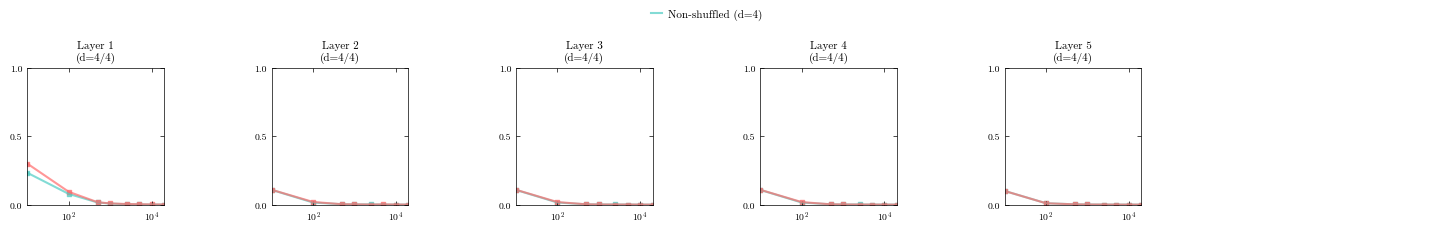

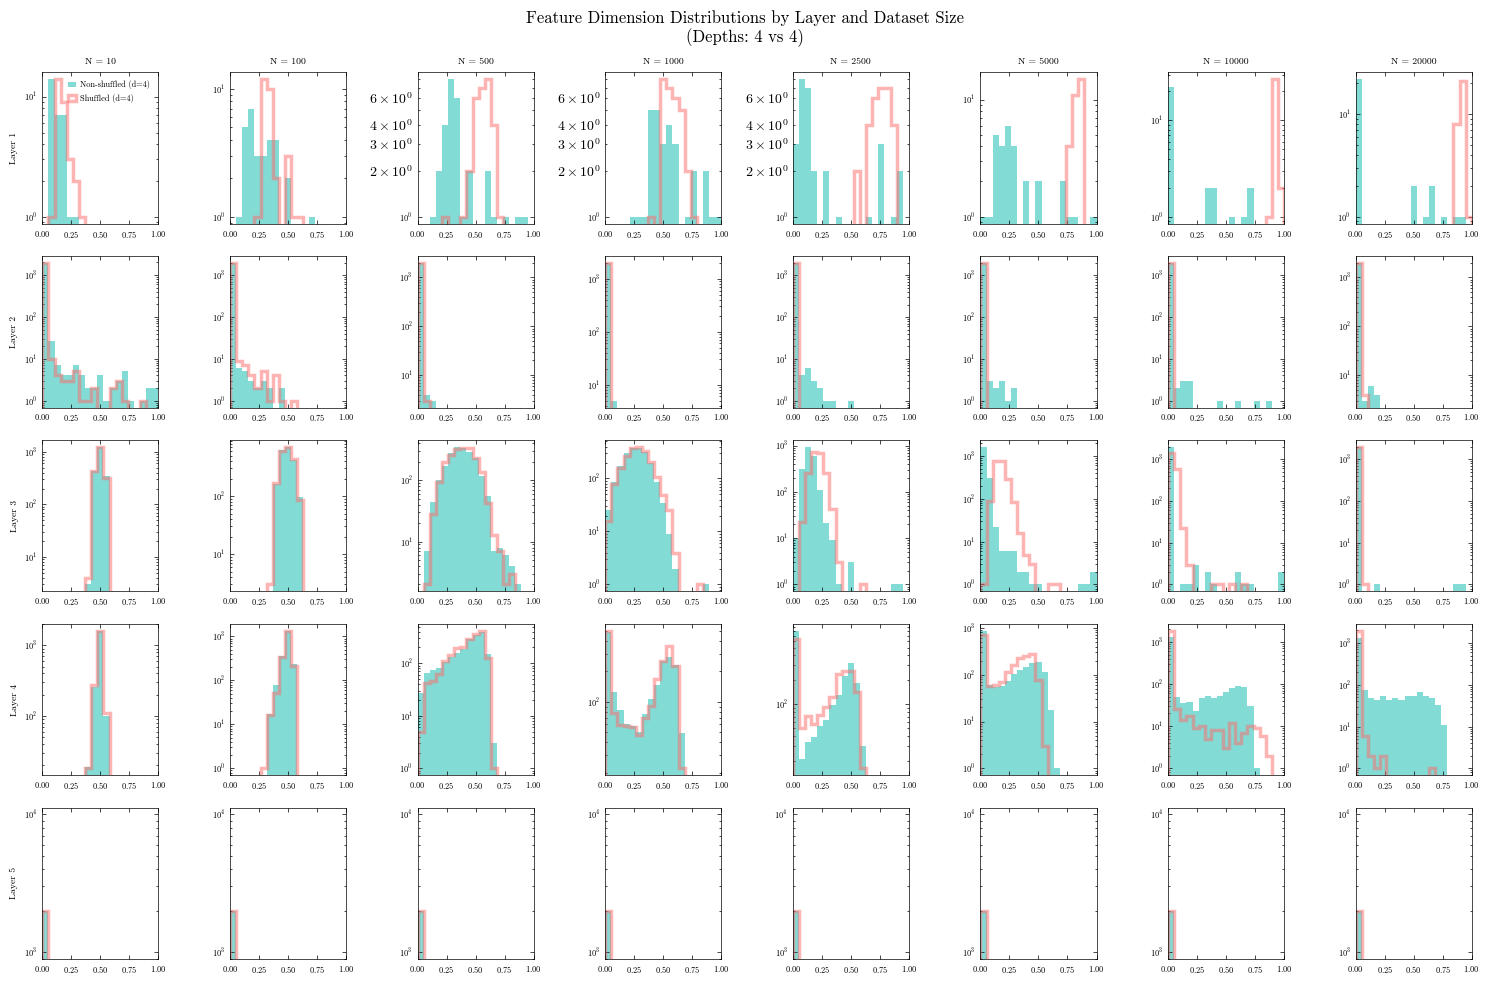

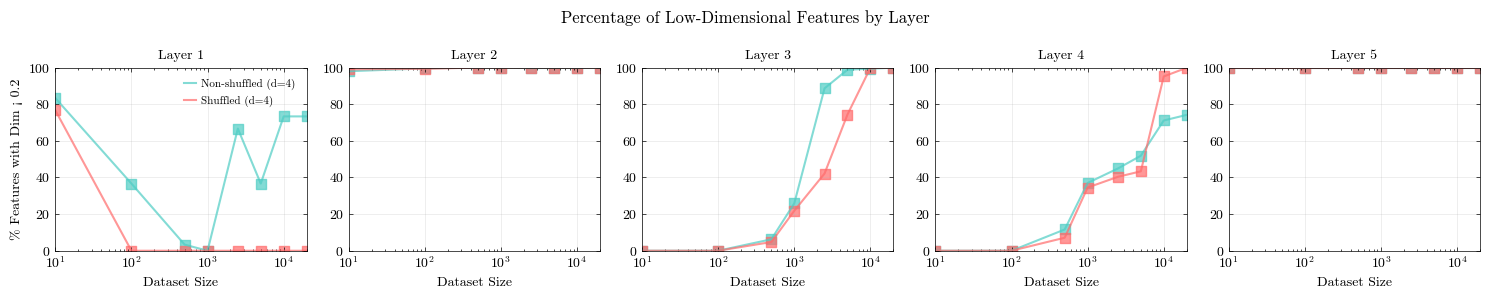

In [42]:
import torch
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List

class DeepNN(torch.nn.Module):
    def __init__(self, d: int, hidden_size: int, depth: int, mode: str = 'standard', gamma: float = 1.0):
        super().__init__()
        torch.set_default_dtype(torch.float32)
        self.gamma = gamma
        self.mode = mode
        self.depth = depth
        self.hidden_size = hidden_size
        self.input_dim = d
        
        layers = []
        prev_dim = d
        
        for layer_idx in range(depth):
            linear = torch.nn.Linear(prev_dim, hidden_size)
            if mode == 'standard':
                torch.nn.init.xavier_uniform_(linear.weight)
                torch.nn.init.zeros_(linear.bias)
            layers.extend([linear, torch.nn.ReLU()])
            prev_dim = hidden_size
        
        final_layer = torch.nn.Linear(prev_dim, 1)
        if mode == 'standard':
            torch.nn.init.xavier_uniform_(final_layer.weight)
        torch.nn.init.zeros_(final_layer.bias)
        layers.append(final_layer)
        
        self.network = torch.nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x).squeeze() / float(self.gamma)

def load_experiment_data(results_dir: str, timestamp: str) -> Tuple[List[Dict], Dict]:
    """Load experiment results and hyperparameters from the given directory"""
    hyperparams_path = os.path.join(results_dir, f'hyperparameters_{timestamp}.json')
    with open(hyperparams_path, 'r') as f:
        hyperparams = json.load(f)
    
    results_path = os.path.join(results_dir, f'final_results_{timestamp}.json')
    with open(results_path, 'r') as f:
        results = json.load(f)
    
    return results, hyperparams

def load_model_and_data(data_dir: str, results_dir: str, result: Dict, timestamp: str) -> Tuple[torch.nn.Module, torch.Tensor, torch.Tensor]:
    """Load the model and its corresponding training data"""
    hyperparams_path = os.path.join(results_dir, f'hyperparameters_{timestamp}.json')
    with open(hyperparams_path, 'r') as f:
        hyperparams = json.load(f)
    input_dim = hyperparams['d']
    
    hidden_size = result['hidden_size']
    depth = result['depth']
    n_train = result['n_train']
    lr = result['learning_rate']
    mode = result.get('mode', 'standard')
    shuffled = result.get('shuffled', False)
    rank = result.get('worker_rank', 0)
    gamma = result.get('gamma', 1.0)
    
    model_prefix = f'h{hidden_size}_d{depth}_n{n_train}_lr{lr}_g{gamma}_{mode}'
    if shuffled:
        model_prefix += '_shuffled'
    
    model_path = os.path.join(results_dir, f'final_model_{model_prefix}_{timestamp}_rank{rank}.pt')
    model = DeepNN(input_dim, hidden_size, depth, mode=mode, gamma=gamma)
    model.load_state_dict(torch.load(model_path))
    
    train_dataset_path = os.path.join(results_dir, f'train_dataset_{model_prefix}_{timestamp}_rank{rank}.pt')
    train_data = torch.load(train_dataset_path)
    
    X_train = train_data['X']
    y_train = train_data['y']
    
    device = next(model.parameters()).device
    model = model.to(device)
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    
    return model, X_train, y_train

def compute_anthropic_dimensionality(hidden: torch.Tensor, features: torch.Tensor) -> Tuple[float, float, float, float, torch.Tensor]:
    """Compute Anthropic's dimensionality metrics"""
    with torch.no_grad():
        # Sample dimensionality
        hidden_norms = torch.norm(hidden, dim=1, keepdim=True)
        normalized_hidden = hidden / (hidden_norms + 1e-8)
        hidden_dots = normalized_hidden @ hidden.T
        hidden_dots_squared = hidden_dots ** 2
        sample_denominator = torch.sum(hidden_dots_squared, dim=1)
        sample_numerator = torch.sum(hidden * hidden, dim=1)
        sample_dims = sample_numerator / (sample_denominator + 1e-8)
        
        sample_mean = float(torch.mean(sample_dims))
        sample_std = float(torch.std(sample_dims))

        # Feature dimensionality
        feature_norms = torch.norm(features, dim=0, keepdim=True)
        normalized_features = features / (feature_norms + 1e-8)
        feature_dots = normalized_features.T @ features
        feature_dots_squared = feature_dots ** 2
        feature_denominator = torch.sum(feature_dots_squared, dim=1)
        feature_numerator = torch.sum(features * features, dim=0)
        feature_dims = feature_numerator / (feature_denominator + 1e-8)
        
        feature_mean = float(torch.mean(feature_dims))
        feature_std = float(torch.std(feature_dims))

        return sample_mean, sample_std, feature_mean, feature_std, feature_dims
def analyze_by_dataset_size(results: List[Dict], hyperparams: Dict, data_dir: str, results_dir: str, 
                         timestamp: str, target_lr=None, target_hidden_size=None, target_depth=None):
    """Analyze metrics for specific model configuration"""
    # Filter results by learning rate and model architecture
    filtered_results = results
    if target_lr is not None:
        filtered_results = [r for r in filtered_results if r['learning_rate'] == target_lr]
    if target_hidden_size is not None:
        filtered_results = [r for r in filtered_results if r['hidden_size'] == target_hidden_size]
    if target_depth is not None:
        filtered_results = [r for r in filtered_results if r['depth'] == target_depth]
    
    # Sort by dataset size
    sorted_results = sorted(filtered_results, key=lambda x: x['n_train'])
    
    if not sorted_results:
        raise ValueError(f"No results found for specified configuration: lr={target_lr}, hidden_size={target_hidden_size}, depth={target_depth}")
    
    metrics = {
        'n_train': [],
        'layers': [],
        'raw_feature_dims': []  # Add storage for raw feature dimensions
    }
    
    for result in sorted_results:
        print(f"Processing result: n_train={result['n_train']}, "
              f"hidden_size={result['hidden_size']}, depth={result['depth']}, "
              f"lr={result['learning_rate']}, "
              f"shuffled={result.get('shuffled', False)}")
        
        model, X_train, y_train = load_model_and_data(data_dir, results_dir, result, timestamp)
        layer_metrics = analyze_dimensionality_by_layer(model, X_train)
        
        metrics['n_train'].append(result['n_train'])
        metrics['layers'].append(layer_metrics)
        
        # Store raw feature dimensions for each layer
        raw_dims = []
        for layer_metric in layer_metrics:
            raw_dims.append(layer_metric['anthropic']['feature_dims_raw'])
        metrics['raw_feature_dims'].append(raw_dims)
    
    return metrics

def extract_metrics_array(metrics: Dict) -> Tuple[np.ndarray, List[List[np.ndarray]], List[List[float]]]:
    """Extract metrics into numpy array and list of raw feature dimension arrays with better dimension handling"""
    if not metrics['layers']:
        raise ValueError("No metrics data found")
        
    n_layers = len(metrics['layers'][0])
    n_datapoints = len(metrics['layers'])
    n_dim_types = 4
    
    result = np.zeros((n_dim_types, n_layers, n_datapoints))
    
    # Process regular metrics
    for dp_idx, layer_metrics in enumerate(metrics['layers']):
        for layer_idx in range(n_layers):
            result[0, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['sample_dim']
            result[1, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['sample_dim_std']
            result[2, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['feature_dim']
            result[3, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['feature_dim_std']
    
    # Process raw feature dimensions - now properly structured as [dataset][layer]
    raw_feature_dims = []
    for dp_idx in range(n_datapoints):
        layer_dims = []
        for layer_idx in range(n_layers):
            dims = metrics['layers'][dp_idx][layer_idx]['anthropic']['feature_dims_raw']
            layer_dims.append(dims)
        raw_feature_dims.append(layer_dims)
    
    # Calculate percentage of feature dimensions below threshold per layer
    low_dim_percentages = [[] for _ in range(n_layers)]
    for layer_idx in range(n_layers):
        for dp_idx in range(n_datapoints):
            feat_dims = raw_feature_dims[dp_idx][layer_idx]
            low_dims = np.sum(feat_dims < 0.2)
            total_dims = len(feat_dims)
            percentage = (low_dims / total_dims) * 100 if total_dims > 0 else 0
            low_dim_percentages[layer_idx].append(percentage)
    
    return result, raw_feature_dims, low_dim_percentages



def analyze_dimensionality_by_layer(model: torch.nn.Module, X: torch.Tensor) -> Dict:
    """Compute dimensionality metrics for each layer"""
    layer_metrics = []
    current_activation = X
    
    with torch.no_grad():
        for i, layer in enumerate(model.network):
            if hasattr(layer, 'weight'):
                features = layer.weight.data
            else:
                continue
            
            current_activation = layer(current_activation)
            
            sample_mean, sample_std, feature_mean, feature_std, feature_dims = compute_anthropic_dimensionality(
                current_activation, features)
            
            layer_metrics.append({
                'layer': i,
                'anthropic': {
                    'sample_dim': sample_mean,
                    'sample_dim_std': sample_std,
                    'feature_dim': feature_mean,
                    'feature_dim_std': feature_std,
                    'feature_dims_raw': feature_dims.cpu().numpy()
                }
            })
    
    return layer_metrics

def plot_dimensionality_comparison(metrics1, metrics2, raw_dims1, raw_dims2, 
                               low_dim_pct1, low_dim_pct2,
                               label1="Model 1", label2="Model 2",
                               sample_figsize=(15.0, 2.0),
                               hist_figsize=(15, 10),
                               low_dim_figsize=(15, 3),
                               depth1=None, depth2=None):
    """Plot dimensionality analysis comparison between two models with safer array handling"""
    # Get dataset sizes from the metrics
    dataset_sizes = metrics1['n_train']
    n_layers = len(metrics1['layers'][0])
    n_datasets = len(dataset_sizes)
    
    print(f"Debug info:")
    print(f"Number of layers: {n_layers}")
    print(f"Number of datasets: {n_datasets}")
    print(f"Dataset sizes: {dataset_sizes}")
    print(f"Raw dims1 structure: {len(raw_dims1)} x {len(raw_dims1[0]) if raw_dims1 else 0}")
    print(f"Raw dims2 structure: {len(raw_dims2)} x {len(raw_dims2[0]) if raw_dims2 else 0}")
    
    # Sample Dimensionality Plot
    fig1, axs1 = plt.subplots(1, n_layers + 1, figsize=sample_figsize)
    fig1.subplots_adjust(wspace=0.01)
    
    sample_dim1 = metrics1_arr[0]
    sample_dim2 = metrics2_arr[0]
    
    # Set up consistent y-axis limits
    y_min = 0.0
    y_max = 1.0
    
    for layer in range(n_layers):
        ax = axs1[layer]
        
        ax.plot(dataset_sizes, sample_dim1[layer], color='#4ECDC4', alpha=0.7, linewidth=1.5)
        ax.plot(dataset_sizes, sample_dim2[layer], color='#FF6B6B', alpha=0.7, linewidth=1.5)
        
        ax.scatter(dataset_sizes, sample_dim1[layer], color='#4ECDC4', marker='s', s=10, alpha=0.7)
        ax.scatter(dataset_sizes, sample_dim2[layer], color='#FF6B6B', marker='s', s=10, alpha=0.7)
        
        layer_title = f'Layer {layer+1}'
        if depth1 is not None and depth2 is not None:
            layer_title += f'\n(d={depth1}/{depth2})'
        ax.set_title(layer_title, fontsize=8)
        
        ax.set_ylim(y_min, y_max)
        ax.set_yticks([0.0, 0.5, 1.0])
        ax.set_yticklabels(['0.0', '0.5', '1.0'], fontsize=7)
        
        ax.set_xscale('log')
        ax.set_xlim(10, 2e4)
        ax.set_xticks([1e2, 1e4])
        ax.set_xticklabels(['$10^2$', '$10^4$'], fontsize=7)
        
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(0.5)
            
        ax.tick_params(width=0.5)
        ax.set_box_aspect(1)
    
    axs1[-1].axis('off')
    
    if depth1 is not None and depth2 is not None:
        label1 = f"{label1} (d={depth1})"
        label2 = f"{label2} (d={depth2})"
    
    lines = axs1[0].get_lines()[::2]
    fig1.legend(lines, [label1, label2],
               loc='upper center',
               bbox_to_anchor=(0.5, 1.2),
               ncol=2,
               fontsize=8,
               frameon=False)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    
    # Feature Dimensionality Histograms with safer array handling
    fig2, axs2 = plt.subplots(n_layers, n_datasets, figsize=hist_figsize)
    title = 'Feature Dimension Distributions by Layer and Dataset Size'
    if depth1 is not None and depth2 is not None:
        title += f'\n(Depths: {depth1} vs {depth2})'
    fig2.suptitle(title, fontsize=12)
    
    x_min, x_max = 0.0, 1.0
    bins = np.linspace(x_min, x_max, 20)  # Reduced number of bins for thicker bars
    
    # Ensure axs2 is always 2D
    if n_layers == 1:
        axs2 = np.array([axs2])
    if n_datasets == 1:
        axs2 = np.array([axs2]).T
    
    for layer in range(n_layers):
        for idx in range(n_datasets):
            try:
                ax = axs2[layer, idx]
                
                # Safely access raw dimensions
                dims1 = raw_dims1[idx][layer] if idx < len(raw_dims1) and layer < len(raw_dims1[idx]) else []
                dims2 = raw_dims2[idx][layer] if idx < len(raw_dims2) and layer < len(raw_dims2[idx]) else []
                
                if len(dims1) > 0:
                    counts1, bins1, patches1 = ax.hist(dims1, bins=bins, alpha=0.7,  # Increased alpha
                                                     color='#4ECDC4', label=label1, 
                                                     histtype='stepfilled',
                                                     linewidth=2.0)  # Increased line width
                if len(dims2) > 0:
                    counts2, bins2, patches2 = ax.hist(dims2, bins=bins, alpha=0.5,
                                                     color='#FF6B6B', label=label2, 
                                                     histtype='step',
                                                     linewidth=2.5,  # Increased line width
                                                     edgecolor='#FF6B6B')
                
                if (len(dims1) > 0 and np.max(counts1) > 0) or (len(dims2) > 0 and np.max(counts2) > 0):
                    ax.set_yscale('log')
                
                ax.set_xlim(x_min, x_max)
                
                if layer == 0:
                    ax.set_title(f'N = {dataset_sizes[idx]}', fontsize=7)
                if idx == 0:
                    ax.set_ylabel(f'Layer {layer+1}', fontsize=7)
                
                ax.tick_params(labelsize=6)
                if layer == 0 and idx == 0:
                    ax.legend(fontsize=6)
                    
            except Exception as e:
                print(f"Error plotting histogram for layer {layer}, dataset {idx}: {str(e)}")
    
    plt.tight_layout()
    
    # Plot low-dimensional feature percentage per layer with safer array handling
    fig3, axs3 = plt.subplots(1, n_layers, figsize=low_dim_figsize)
    fig3.suptitle('Percentage of Low-Dimensional Features by Layer', fontsize=12)
    
    # Ensure axs3 is an array
    axs3 = np.atleast_1d(axs3)
    
    for layer in range(n_layers):
        ax = axs3[layer] if n_layers > 1 else axs3[0]
        
        try:
            ax.plot(dataset_sizes, low_dim_pct1[layer], color='#4ECDC4', alpha=0.7, linewidth=1.5, label=label1)
            ax.plot(dataset_sizes, low_dim_pct2[layer], color='#FF6B6B', alpha=0.7, linewidth=1.5, label=label2)
            
            ax.scatter(dataset_sizes, low_dim_pct1[layer], color='#4ECDC4', marker='s', s=50, alpha=0.7)
            ax.scatter(dataset_sizes, low_dim_pct2[layer], color='#FF6B6B', marker='s', s=50, alpha=0.7)
        except Exception as e:
            print(f"Error plotting low-dim percentages for layer {layer}: {str(e)}")
        
        ax.set_xscale('log')
        ax.set_xlim(10, 2e4)
        ax.set_ylim(0, 100)
        
        ax.set_xlabel('Dataset Size', fontsize=10)
        if layer == 0:
            ax.set_ylabel('% Features with Dim < 0.2', fontsize=10)
        
        ax.set_title(f'Layer {layer+1}', fontsize=10)
        if layer == 0:
            ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()



# Add this debug function
def print_metrics_info(metrics, raw_dims, label):
    print(f"\nDebug info for {label}:")
    print(f"Number of training sizes: {len(metrics['n_train'])}")
    print(f"Training sizes: {metrics['n_train']}")
    print(f"Number of layers: {len(metrics['layers'][0])}")
    print(f"Raw dimensions structure:")
    print(f"- Number of datasets: {len(raw_dims)}")
    if raw_dims:
        print(f"- Dimensions per layer: {[len(layer_dims) for layer_dims in raw_dims[0]]}")
    
# Before plotting, add debug info
#print_metrics_info(metrics1, raw_dims1, "Model 1 (Non-shuffled)")
#print_metrics_info(metrics2, raw_dims2, "Model 2 (Shuffled)")

# Example usage
results_dir1 = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_anthro_false_mup_lr0005_gamma_0001_modelsaved"
results_dir2 = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_anthro_true_mup_lr0005_gamma_0001_modelsaved"
timestamp1 = "20250126_043809"  # First model timestamp
timestamp2 = "20250126_043702"  # Second model timestamp
hidden_size = 2000  # The hidden size to analyze
depth = 4 # The depth to analyze
target_lr = 0.005  # The learning rate used in training
gamma = 0.001  # The gamma value used in training
dataset_sizes = [10, 100, 500, 1000, 5000, 10000, 20000]  # The actual dataset sizes used
# Example usage with added debugging
print("Loading and analyzing first model (non-shuffled)...")
results1, hyperparams1 = load_experiment_data(results_dir1, timestamp1)
metrics1 = analyze_by_dataset_size(
    results1, 
    hyperparams1, 
    results_dir1, 
    results_dir1, 
    timestamp1, 
    target_lr=target_lr,
    target_hidden_size=hidden_size,
    target_depth=depth
)

print("\nLoading and analyzing second model (shuffled)...")
results2, hyperparams2 = load_experiment_data(results_dir2, timestamp2)
metrics2 = analyze_by_dataset_size(
    results2, 
    hyperparams2, 
    results_dir2, 
    results_dir2, 
    timestamp2, 
    target_lr=target_lr,
    target_hidden_size=hidden_size,
    target_depth=depth
)

# Extract arrays with debugging information
print("\nExtracting metrics arrays...")
metrics1_arr, raw_dims1, low_dim_pct1 = extract_metrics_array(metrics1)
metrics2_arr, raw_dims2, low_dim_pct2 = extract_metrics_array(metrics2)

# Additional debugging prints
print(f"\nMetrics shapes:")
print(f"metrics1_arr shape: {metrics1_arr.shape}")
print(f"metrics2_arr shape: {metrics2_arr.shape}")
print(f"Number of dataset sizes: {len(metrics1['n_train'])}")
print(f"Dataset sizes in first model: {metrics1['n_train']}")
print(f"Dataset sizes in second model: {metrics2['n_train']}")

# Plot with additional debugging information
print("\nPlotting comparison...")
plot_dimensionality_comparison(
    metrics1, 
    metrics2, 
    raw_dims1, 
    raw_dims2, 
    low_dim_pct1,
    low_dim_pct2,
    label1="Non-shuffled",
    label2="Shuffled",
    depth1=depth,
    depth2=depth
)

In [43]:
def plot_dimensionality_comparison(metrics1, metrics2, raw_dims1, raw_dims2, 
                               low_dim_pct1, low_dim_pct2,
                               label1="Model 1", label2="Model 2",
                               sample_figsize=(15.0, 2.0),
                               hist_figsize=(15, 10),
                               low_dim_figsize=(15, 3),
                               save_path="./"):
    """
    Plot dimensionality analysis comparison between two models and save as SVG files
    
    Args:
        metrics1, metrics2: Dictionaries containing metrics for both models
        raw_dims1, raw_dims2: Lists of raw dimension data for both models
        low_dim_pct1, low_dim_pct2: Lists of low dimensionality percentages
        label1, label2: Labels for the two models
        *_figsize: Figure sizes for different plots
        save_path: Directory to save SVG files
    """
    dataset_sizes = metrics1['n_train']
    n_layers = len(metrics1['layers'][0])
    n_datasets = len(dataset_sizes)
    
    # Sample Dimensionality Plot
    fig1, axs1 = plt.subplots(1, n_layers + 1, figsize=sample_figsize)
    fig1.subplots_adjust(wspace=0.01)
    
    sample_dim1 = metrics1_arr[0]
    sample_dim2 = metrics2_arr[0]
    
    y_min, y_max = 0.0, 1.0
    
    for layer in range(n_layers):
        ax = axs1[layer]
        
        ax.plot(dataset_sizes, sample_dim1[layer], color='#4ECDC4', alpha=0.7, linewidth=1.5)
        ax.plot(dataset_sizes, sample_dim2[layer], color='#FF6B6B', alpha=0.7, linewidth=1.5)
        
        ax.scatter(dataset_sizes, sample_dim1[layer], color='#4ECDC4', marker='s', s=10, alpha=0.7)
        ax.scatter(dataset_sizes, sample_dim2[layer], color='#FF6B6B', marker='s', s=10, alpha=0.7)
        
        ax.set_title(f'Layer {layer+1}', fontsize=8)
        ax.set_ylim(y_min, y_max)
        ax.set_yticks([0.0, 0.5, 1.0])
        ax.set_yticklabels(['0.0', '0.5', '1.0'], fontsize=7)
        
        ax.set_xscale('log')
        ax.set_xlim(10, 2e4)
        ax.set_xticks([1e2, 1e4])
        ax.set_xticklabels(['$10^2$', '$10^4$'], fontsize=7)
        
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(0.5)
            
        ax.tick_params(width=0.5)
        ax.set_box_aspect(1)
    
    axs1[-1].axis('off')
    
    lines = axs1[0].get_lines()[::2]
    fig1.legend(lines, [label1, label2],
               loc='upper center',
               bbox_to_anchor=(0.5, 1.2),
               ncol=2,
               fontsize=8,
               frameon=False)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.savefig(f'{save_path}/sample_dimensionality2.svg', format='svg', bbox_inches='tight')
    plt.close(fig1)
    
    # Feature Dimensionality Histograms
    fig2, axs2 = plt.subplots(n_layers, n_datasets, figsize=hist_figsize)
    fig2.suptitle('Feature Dimension Distributions by Layer and Dataset Size', fontsize=12)
    
    x_min, x_max = 0.0, 1.0
    bins = np.linspace(x_min, x_max, 20)
    
    if n_layers == 1:
        axs2 = np.array([axs2])
    if n_datasets == 1:
        axs2 = np.array([axs2]).T
    
    for layer in range(n_layers):
        for idx in range(n_datasets):
            try:
                ax = axs2[layer, idx]
                
                dims1 = raw_dims1[idx][layer] if idx < len(raw_dims1) and layer < len(raw_dims1[idx]) else []
                dims2 = raw_dims2[idx][layer] if idx < len(raw_dims2) and layer < len(raw_dims2[idx]) else []
                
                if len(dims1) > 0:
                    counts1, bins1, patches1 = ax.hist(dims1, bins=bins, alpha=0.7,
                                                     color='#4ECDC4', label=label1, 
                                                     histtype='stepfilled',
                                                     linewidth=2.0)
                if len(dims2) > 0:
                    counts2, bins2, patches2 = ax.hist(dims2, bins=bins, alpha=0.5,
                                                     color='#FF6B6B', label=label2, 
                                                     histtype='step',
                                                     linewidth=2.5,
                                                     edgecolor='#FF6B6B')
                
                if (len(dims1) > 0 and np.max(counts1) > 0) or (len(dims2) > 0 and np.max(counts2) > 0):
                    ax.set_yscale('log')
                
                ax.set_xlim(x_min, x_max)
                
                if layer == 0:
                    ax.set_title(f'N = {dataset_sizes[idx]}', fontsize=7)
                if idx == 0:
                    ax.set_ylabel(f'Layer {layer+1}', fontsize=7)
                
                ax.tick_params(labelsize=6)
                if layer == 0 and idx == 0:
                    ax.legend(fontsize=6)
                    
            except Exception as e:
                print(f"Error plotting histogram for layer {layer}, dataset {idx}: {str(e)}")
    
    plt.tight_layout()
    plt.savefig(f'{save_path}/feature_distributions2.svg', format='svg', bbox_inches='tight')
    plt.close(fig2)
    
    # Low-dimensional feature percentage plot
    fig3, axs3 = plt.subplots(1, n_layers, figsize=low_dim_figsize)
    fig3.suptitle('Percentage of Low-Dimensional Features by Layer', fontsize=12)
    
    axs3 = np.atleast_1d(axs3)
    
    for layer in range(n_layers):
        ax = axs3[layer] if n_layers > 1 else axs3[0]
        
        try:
            ax.plot(dataset_sizes, low_dim_pct1[layer], color='#4ECDC4', alpha=0.7, linewidth=1.5, label=label1)
            ax.plot(dataset_sizes, low_dim_pct2[layer], color='#FF6B6B', alpha=0.7, linewidth=1.5, label=label2)
            
            ax.scatter(dataset_sizes, low_dim_pct1[layer], color='#4ECDC4', marker='s', s=50, alpha=0.7)
            ax.scatter(dataset_sizes, low_dim_pct2[layer], color='#FF6B6B', marker='s', s=50, alpha=0.7)
        except Exception as e:
            print(f"Error plotting low-dim percentages for layer {layer}: {str(e)}")
        
        ax.set_xscale('log')
        ax.set_xlim(10, 2e4)
        ax.set_ylim(0, 100)
        
        ax.set_xlabel('Dataset Size', fontsize=10)
        if layer == 0:
            ax.set_ylabel('% Features with Dim < 0.2', fontsize=10)
        
        ax.set_title(f'Layer {layer+1}', fontsize=10)
        if layer == 0:
            ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{save_path}/low_dim_percentages2.svg', format='svg', bbox_inches='tight')
    plt.close(fig3)

plot_dimensionality_comparison(
    metrics1, 
    metrics2, 
    raw_dims1, 
    raw_dims2, 
    low_dim_pct1,
    low_dim_pct2,
    label1="non-shuffled",
    label2="shuffled",
    save_path="/mnt/users/goringn/NNs_vs_Kernels/figures/histo_anthro"  # Specify your desired save directory
)

In [ ]:
######### plot

Processing result: n_train=10


/tmp/ipykernel_1958516/619497292.py:110: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(train_dataset_path)
/tmp/ipykernel_1958516/619497292.py:116: F

Processing result: n_train=100
Processing result: n_train=500
Processing result: n_train=1000
Processing result: n_train=2500
Processing result: n_train=5000
Processing result: n_train=10000
Processing result: n_train=20000
Processing result: n_train=10
Processing result: n_train=100
Processing result: n_train=500
Processing result: n_train=1000
Processing result: n_train=2500
Processing result: n_train=5000
Processing result: n_train=10000
Processing result: n_train=20000


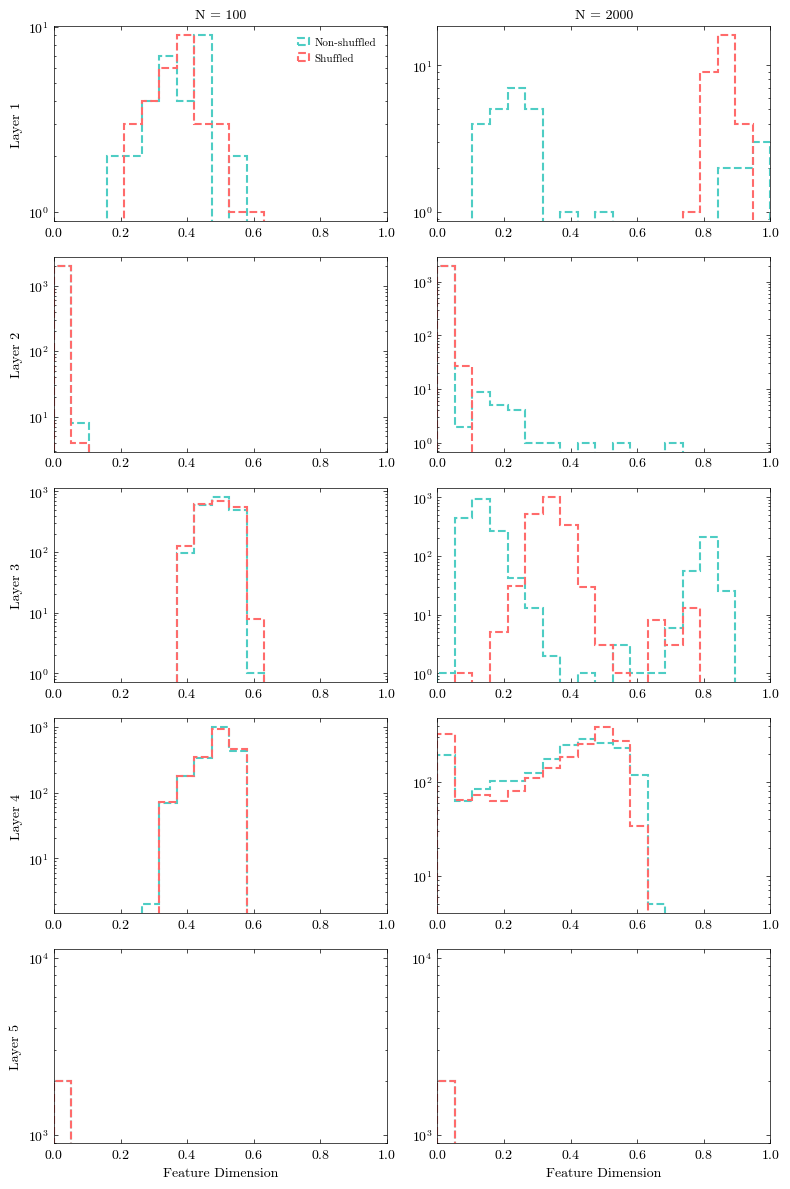

In [ ]:
import torch
import numpy as np

class DeepNN(torch.nn.Module):
    def __init__(self, d: int, hidden_size: int, depth: int, mode: str = 'standard', gamma: float = 1.0):
        super().__init__()
        torch.set_default_dtype(torch.float32)
        self.gamma = gamma
        self.mode = mode
        self.depth = depth
        self.hidden_size = hidden_size
        self.input_dim = d
        
        layers = []
        prev_dim = d
        
        for layer_idx in range(depth):
            linear = torch.nn.Linear(prev_dim, hidden_size)
            if mode == 'standard':
                torch.nn.init.xavier_uniform_(linear.weight)
                torch.nn.init.zeros_(linear.bias)
            layers.extend([linear, torch.nn.ReLU()])
            prev_dim = hidden_size
        
        final_layer = torch.nn.Linear(prev_dim, 1)
        if mode == 'standard':
            torch.nn.init.xavier_uniform_(final_layer.weight)
        torch.nn.init.zeros_(final_layer.bias)
        layers.append(final_layer)
        
        self.network = torch.nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x).squeeze() / float(self.gamma)
import matplotlib.pyplot as plt
import matplotlib as mpl
from typing import Dict, List, Tuple
import json
import os

def setup_science_style():
    plt.style.use('default')
    mpl.rcParams.update({
        'figure.dpi': 100,
        'font.family': 'serif',
        'font.serif': ['cmr10', 'Computer Modern Serif', 'DejaVu Serif'],
        'text.usetex': False,
        'axes.formatter.use_mathtext': True,
        'mathtext.fontset': 'cm',
        'axes.linewidth': 0.5,
        'axes.spines.top': True,
        'axes.spines.right': True,
        'axes.spines.left': True,
        'axes.spines.bottom': True,
        'xtick.direction': 'in',
        'ytick.direction': 'in',
        'xtick.major.width': 0.5,
        'ytick.major.width': 0.5,
        'xtick.minor.width': 0.5,
        'ytick.minor.width': 0.5,
        'xtick.major.size': 3,
        'ytick.major.size': 3,
        'xtick.minor.size': 1.5,
        'ytick.minor.size': 1.5,
        'xtick.top': True,
        'ytick.right': True,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.0,
        'lines.markersize': 3,
        'legend.frameon': False,
        'legend.borderpad': 0,
        'legend.borderaxespad': 1.0,
        'legend.handlelength': 1.0,
        'legend.handletextpad': 0.5,
    })

def load_experiment_data(results_dir: str, timestamp: str) -> Tuple[List[Dict], Dict]:
    """Load experiment results and hyperparameters"""
    hyperparams_path = os.path.join(results_dir, f'hyperparameters_{timestamp}.json')
    with open(hyperparams_path, 'r') as f:
        hyperparams = json.load(f)
    
    results_path = os.path.join(results_dir, f'final_results_{timestamp}.json')
    with open(results_path, 'r') as f:
        results = json.load(f)
    
    return results, hyperparams

def analyze_by_dataset_size(results: List[Dict], hyperparams: Dict, results_dir: str, timestamp: str, 
                          target_lr=None, target_hidden_size=None, target_depth=None):
    """Filter and analyze results for specific configuration"""
    filtered_results = results
    if target_lr is not None:
        filtered_results = [r for r in filtered_results if r['learning_rate'] == target_lr]
    if target_hidden_size is not None:
        filtered_results = [r for r in filtered_results if r['hidden_size'] == target_hidden_size]
    if target_depth is not None:
        filtered_results = [r for r in filtered_results if r['depth'] == target_depth]
    
    sorted_results = sorted(filtered_results, key=lambda x: x['n_train'])
    metrics = {'n_train': [], 'layers': [], 'raw_feature_dims': []}
    
    for result in sorted_results:
        print(f"Processing result: n_train={result['n_train']}")
        model_prefix = f"h{result['hidden_size']}_d{result['depth']}_n{result['n_train']}_lr{result['learning_rate']}_g{result.get('gamma', 1.0)}_{result.get('mode', 'standard')}"
        if result.get('shuffled', False):
            model_prefix += '_shuffled'
        
        train_dataset_path = os.path.join(results_dir, f'train_dataset_{model_prefix}_{timestamp}_rank{result.get("worker_rank", 0)}.pt')
        train_data = torch.load(train_dataset_path)
        
        model_path = os.path.join(results_dir, f'final_model_{model_prefix}_{timestamp}_rank{result.get("worker_rank", 0)}.pt')
        model = DeepNN(hyperparams['d'], result['hidden_size'], result['depth'], 
                      mode=result.get('mode', 'standard'), 
                      gamma=result.get('gamma', 1.0))
        model.load_state_dict(torch.load(model_path))
        
        layer_metrics = analyze_dimensionality_by_layer(model, train_data['X'])
        
        metrics['n_train'].append(result['n_train'])
        metrics['layers'].append(layer_metrics)
        raw_dims = []
        for layer_metric in layer_metrics:
            raw_dims.append(layer_metric['anthropic']['feature_dims_raw'])
        metrics['raw_feature_dims'].append(raw_dims)
    
    return metrics

def compute_anthropic_dimensionality(hidden: torch.Tensor, features: torch.Tensor) -> Tuple[float, float, float, float, torch.Tensor]:
    """Compute Anthropic's dimensionality metrics"""
    with torch.no_grad():
        # Sample dimensionality
        hidden_norms = torch.norm(hidden, dim=1, keepdim=True)
        normalized_hidden = hidden / (hidden_norms + 1e-8)
        hidden_dots = normalized_hidden @ hidden.T
        hidden_dots_squared = hidden_dots ** 2
        sample_denominator = torch.sum(hidden_dots_squared, dim=1)
        sample_numerator = torch.sum(hidden * hidden, dim=1)
        sample_dims = sample_numerator / (sample_denominator + 1e-8)
        
        sample_mean = float(torch.mean(sample_dims))
        sample_std = float(torch.std(sample_dims))

        # Feature dimensionality
        feature_norms = torch.norm(features, dim=0, keepdim=True)
        normalized_features = features / (feature_norms + 1e-8)
        feature_dots = normalized_features.T @ features
        feature_dots_squared = feature_dots ** 2
        feature_denominator = torch.sum(feature_dots_squared, dim=1)
        feature_numerator = torch.sum(features * features, dim=0)
        feature_dims = feature_numerator / (feature_denominator + 1e-8)
        
        feature_mean = float(torch.mean(feature_dims))
        feature_std = float(torch.std(feature_dims))

        return sample_mean, sample_std, feature_mean, feature_std, feature_dims

def analyze_dimensionality_by_layer(model: torch.nn.Module, X: torch.Tensor) -> Dict:
    """Compute dimensionality metrics for each layer"""
    layer_metrics = []
    current_activation = X
    
    with torch.no_grad():
        for i, layer in enumerate(model.network):
            if hasattr(layer, 'weight'):
                features = layer.weight.data
            else:
                continue
            
            current_activation = layer(current_activation)
            
            sample_mean, sample_std, feature_mean, feature_std, feature_dims = compute_anthropic_dimensionality(
                current_activation, features)
            
            layer_metrics.append({
                'layer': i,
                'anthropic': {
                    'sample_dim': sample_mean,
                    'sample_dim_std': sample_std,
                    'feature_dim': feature_mean,
                    'feature_dim_std': feature_std,
                    'feature_dims_raw': feature_dims.cpu().numpy()
                }
            })
    
    return layer_metrics

def plot_feature_dim_histograms(metrics1, metrics2, target_sizes=[100, 20000]):
    setup_science_style()
    
    n_layers = len(metrics1['layers'][0])
    fig, axs = plt.subplots(n_layers, len(target_sizes), figsize=(8, 12))
    
    x_min, x_max = 0.0, 1.0
    bins = np.linspace(x_min, x_max, 20)
    
    for layer in range(n_layers):
        for i, target_size in enumerate(target_sizes):
            ax = axs[layer, i]
            
            # Find closest dataset size
            idx1 = min(range(len(metrics1['n_train'])), 
                      key=lambda j: abs(metrics1['n_train'][j] - target_size))
            idx2 = min(range(len(metrics2['n_train'])), 
                      key=lambda j: abs(metrics2['n_train'][j] - target_size))
            
            dims1 = metrics1['raw_feature_dims'][idx1][layer]
            dims2 = metrics2['raw_feature_dims'][idx2][layer]
            
            # Plot histograms with dashed lines and no fill
            ax.hist(dims1, bins=bins, histtype='step', linestyle='--',
                   color='#4ECDC4', label='Non-shuffled', alpha=1.0, linewidth=1.5)
            ax.hist(dims2, bins=bins, histtype='step', linestyle='--',
                   color='#FF6B6B', label='Shuffled', alpha=1.0, linewidth=1.5)
            
            ax.set_yscale('log')
            ax.set_xlim(x_min, x_max)
            
            if layer == 0:
                ax.set_title(f'N = {target_size}', fontsize=10)
            if i == 0:
                ax.set_ylabel(f'Layer {layer+1}', fontsize=10)
            if layer == n_layers-1:
                ax.set_xlabel('Feature Dimension', fontsize=10)
            if layer == 0 and i == 0:
                ax.legend(fontsize=8)
            
            # Set tick parameters
            ax.tick_params(which='both', direction='in', top=True, right=True)
            
    plt.tight_layout()
    return fig

# Example usage
results_dir1 = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_anthro_false_mup_lr0005_gamma_1_modelsaved"
results_dir2 = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_anthro_true_mup_lr0005_gamma_1_modelsaved"
timestamp1 = "20250125_153135"
timestamp2 = "20250125_153042"

# Load and analyze data
results1, hyperparams1 = load_experiment_data(results_dir1, timestamp1)
results2, hyperparams2 = load_experiment_data(results_dir2, timestamp2)

metrics1 = analyze_by_dataset_size(
    results1, hyperparams1, results_dir1, timestamp1,
    target_lr=0.005, target_hidden_size=2000, target_depth=4
)

metrics2 = analyze_by_dataset_size(
    results2, hyperparams2, results_dir2, timestamp2,
    target_lr=0.005, target_hidden_size=2000, target_depth=4
)

# Create and save the plot


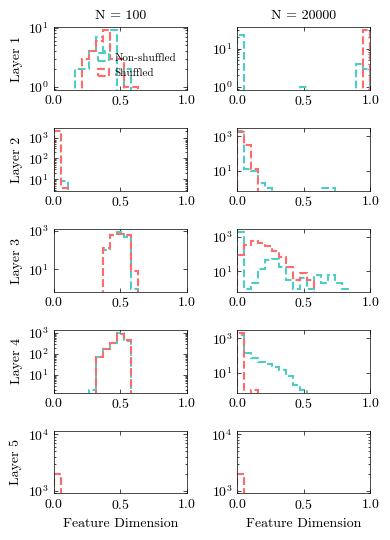

In [15]:

def setup_science_style():
    plt.style.use('default')
    mpl.rcParams.update({
        'figure.dpi': 100,
        'font.family': 'serif',
        'font.serif': ['cmr10', 'Computer Modern Serif', 'DejaVu Serif'],
        'text.usetex': False,
        'axes.formatter.use_mathtext': True,
        'mathtext.fontset': 'cm',
        'axes.linewidth': 0.5,
        'axes.spines.top': True,
        'axes.spines.right': True,
        'axes.spines.left': True,
        'axes.spines.bottom': True,
        'xtick.direction': 'in',
        'ytick.direction': 'in',
        'xtick.major.width': 0.5,
        'ytick.major.width': 0.5,
        'xtick.minor.width': 0.5,
        'ytick.minor.width': 0.5,
        'xtick.major.size': 3,
        'ytick.major.size': 3,
        'xtick.minor.size': 1.5,
        'ytick.minor.size': 1.5,
        'xtick.top': True,
        'ytick.right': True,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.0,
        'lines.markersize': 3,
        'legend.frameon': False,
        'legend.borderpad': 0,
        'legend.borderaxespad': 1.0,
        'legend.handlelength': 1.0,
        'legend.handletextpad': 0.5,
    })




def analyze_dimensionality_by_layer(model: torch.nn.Module, X: torch.Tensor) -> Dict:
    """Compute dimensionality metrics for each layer"""
    layer_metrics = []
    current_activation = X
    
    with torch.no_grad():
        for i, layer in enumerate(model.network):
            if hasattr(layer, 'weight'):
                features = layer.weight.data
            else:
                continue
            
            current_activation = layer(current_activation)
            
            sample_mean, sample_std, feature_mean, feature_std, feature_dims = compute_anthropic_dimensionality(
                current_activation, features)
            
            layer_metrics.append({
                'layer': i,
                'anthropic': {
                    'sample_dim': sample_mean,
                    'sample_dim_std': sample_std,
                    'feature_dim': feature_mean,
                    'feature_dim_std': feature_std,
                    'feature_dims_raw': feature_dims.cpu().numpy()
                }
            })
    
    return layer_metrics

def plot_feature_dim_histograms(metrics1, metrics2, target_sizes=[100, 20000]):
    setup_science_style()
    
    n_layers = len(metrics1['layers'][0])
    fig, axs = plt.subplots(n_layers, len(target_sizes), figsize=(4, 5.5))
    
    x_min, x_max = 0.0, 1.0
    bins = np.linspace(x_min, x_max, 20)
    
    for layer in range(n_layers):
        for i, target_size in enumerate(target_sizes):
            ax = axs[layer, i]
            
            # Find closest dataset size
            idx1 = min(range(len(metrics1['n_train'])), 
                      key=lambda j: abs(metrics1['n_train'][j] - target_size))
            idx2 = min(range(len(metrics2['n_train'])), 
                      key=lambda j: abs(metrics2['n_train'][j] - target_size))
            
            dims1 = metrics1['raw_feature_dims'][idx1][layer]
            dims2 = metrics2['raw_feature_dims'][idx2][layer]
            
            # Plot histograms with dashed lines and no fill
            ax.hist(dims1, bins=bins, histtype='step', linestyle='--',
                   color='#4ECDC4', label='Non-shuffled', alpha=1.0, linewidth=1.5)
            ax.hist(dims2, bins=bins, histtype='step', linestyle='--',
                   color='#FF6B6B', label='Shuffled', alpha=1.0, linewidth=1.5)
            
            ax.set_yscale('log')
            ax.set_xlim(x_min, x_max)
            
            if layer == 0:
                ax.set_title(f'N = {target_size}', fontsize=10)
            if i == 0:
                ax.set_ylabel(f'Layer {layer+1}', fontsize=10)
            if layer == n_layers-1:
                ax.set_xlabel('Feature Dimension', fontsize=10)
            if layer == 0 and i == 0:
                ax.legend(fontsize=8)
            
            # Set tick parameters
            ax.tick_params(which='both', direction='in', top=True, right=True)
            
    plt.tight_layout()
    return fig



fig = plot_feature_dim_histograms(metrics1, metrics2)
plt.savefig('feature_dim_histograms.png', dpi=300, bbox_inches='tight')
plt.savefig('feature_dim_histograms.svg', bbox_inches='tight')
plt.show()

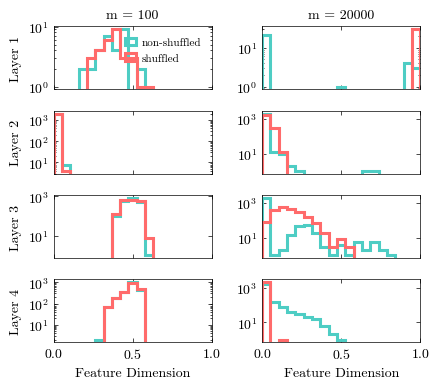

In [39]:

def setup_science_style():
    plt.style.use('default')
    mpl.rcParams.update({
        'figure.dpi': 100,
        'font.family': 'serif',
        'font.serif': ['cmr10', 'Computer Modern Serif', 'DejaVu Serif'],
        'text.usetex': False,
        'axes.formatter.use_mathtext': True,
        'mathtext.fontset': 'cm',
        'axes.linewidth': 0.5,
        'axes.spines.top': True,
        'axes.spines.right': True,
        'axes.spines.left': True,
        'axes.spines.bottom': True,
        'xtick.direction': 'in',
        'ytick.direction': 'in',
        'xtick.major.width': 0.5,
        'ytick.major.width': 0.5,
        'xtick.minor.width': 0.5,
        'ytick.minor.width': 0.5,
        'xtick.major.size': 3,
        'ytick.major.size': 3,
        'xtick.minor.size': 1.5,
        'ytick.minor.size': 1.5,
        'xtick.top': True,
        'ytick.right': True,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.0,
        'lines.markersize': 3,
        'legend.frameon': False,
        'legend.borderpad': 0,
        'legend.borderaxespad': 1.0,
        'legend.handlelength': 1.0,
        'legend.handletextpad': 0.5,
    })




def analyze_dimensionality_by_layer(model: torch.nn.Module, X: torch.Tensor) -> Dict:
    """Compute dimensionality metrics for each layer"""
    layer_metrics = []
    current_activation = X
    
    with torch.no_grad():
        for i, layer in enumerate(model.network):
            if hasattr(layer, 'weight'):
                features = layer.weight.data
            else:
                continue
            
            current_activation = layer(current_activation)
            
            sample_mean, sample_std, feature_mean, feature_std, feature_dims = compute_anthropic_dimensionality(
                current_activation, features)
            
            layer_metrics.append({
                'layer': i,
                'anthropic': {
                    'sample_dim': sample_mean,
                    'sample_dim_std': sample_std,
                    'feature_dim': feature_mean,
                    'feature_dim_std': feature_std,
                    'feature_dims_raw': feature_dims.cpu().numpy()
                }
            })
    
    return layer_metrics

def plot_feature_dim_histograms(metrics1, metrics2, target_sizes=[100, 20000]):
    setup_science_style()
    
    n_layers = 4  # Fixed to 4 layers
    fig, axs = plt.subplots(n_layers, len(target_sizes), figsize=(4.5, 4))
    
    x_min, x_max = 0.0, 1.0
    bins = np.linspace(x_min, x_max, 20)
    
    for layer in range(n_layers):
        for i, target_size in enumerate(target_sizes):
            ax = axs[layer, i]
            
            # Find closest dataset size
            idx1 = min(range(len(metrics1['n_train'])), 
                      key=lambda j: abs(metrics1['n_train'][j] - target_size))
            idx2 = min(range(len(metrics2['n_train'])), 
                      key=lambda j: abs(metrics2['n_train'][j] - target_size))
            
            dims1 = metrics1['raw_feature_dims'][idx1][layer]
            dims2 = metrics2['raw_feature_dims'][idx2][layer]
            
            # Plot histograms with dashed lines and no fill
            ax.hist(dims1, bins=bins, histtype='step', linestyle='-',
                   color='#4ECDC4', label='non-shuffled', alpha=1.0, linewidth=2.2)
            ax.hist(dims2, bins=bins, histtype='step', linestyle='-',
                   color='#FF6B6B', label='shuffled', alpha=1.0, linewidth=2.2)
            
            ax.set_yscale('log')
            ax.set_xlim(x_min, x_max)
            
            # Only show x-axis ticks and label for bottom row
            if layer < n_layers - 1:
                ax.set_xticklabels([])
            
            if layer == 0:
                ax.set_title(f'm = {target_size}', fontsize=10)
            if i == 0:
                ax.set_ylabel(f'Layer {layer+1}', fontsize=10)
            if layer == n_layers-1:
                ax.set_xlabel('Feature Dimension', fontsize=10)
            if layer == 0 and i == 0:
                ax.legend(fontsize=8)
            
            # Set tick parameters
            ax.tick_params(which='both', direction='in', top=True, right=True)
            
            # Remove x-axis labels for all but bottom row
            if layer < n_layers - 1:
                ax.set_xlabel('')
    
    plt.tight_layout()
    return fig

# Example usage:
# fig = plot_feature_dim_histograms(metrics1, metrics2)
# plt.savefig('feature_dim_histograms.png', dpi=300, bbox_inches='tight')
# plt.savefig('feature_dim_histograms.svg', bbox_inches='tight')
# plt.show()



fig = plot_feature_dim_histograms(metrics1, metrics2)
plt.savefig('feature_dim_histograms.png', dpi=300, bbox_inches='tight')
plt.savefig('12feature_dim_histograms.svg', bbox_inches='tight')
plt.show()